## TODO compare offset-subtraction to low-pass filtering

In [1]:
# constant-pad outside of probe mask

In [1]:
def init():
    from ptycho import params as p
    p.cfg['positions.provided'] = True
    p.cfg['data_source'] = 'lines'
    p.cfg['set_phi'] = False
    p.cfg['nepochs'] = 15
    
    p.cfg['nll_weight'] = 1.
    p.cfg['mae_weight'] = 0.

    p.cfg['offset'] = 2
    p.cfg['max_position_jitter'] = 10
    p.cfg['output_prefix'] = 'tmp'

    p.cfg['gridsize'] = 2
    p.cfg['n_filters_scale'] = 2
    p.cfg['object.big'] = True
    p.cfg['intensity_scale.trainable'] = True
    p.cfg['probe.trainable'] = False
    p.cfg['probe.mask'] = False
    p.cfg['nphotons'] = 1e9
    
    p.cfg['outer_offset_train'] = 4
    p.cfg['outer_offset_test'] = 10
    p.cfg['nimgs_train'] = 1
    p.cfg['nimgs_test'] = 1
    
from scipy.ndimage import zoom
import numpy as np

def shrinkpad(image):
    original_shape = image.shape
    # Shrink the image by a factor of two
    shrunken_image = zoom(image, 0.5)

    # Calculate the padding required
    pad_height = original_shape[0] - shrunken_image.shape[0]
    pad_width = original_shape[1] - shrunken_image.shape[1]

    # Pad the shrunken image to the original shape
    padded_image = np.pad(shrunken_image, ((pad_height // 2, pad_height // 2), (pad_width // 2, pad_width // 2)), mode='constant')
    return padded_image

def zoomclip(image):
    n, m = image.shape
    zoomed = zoom(image, 2)
    return zoomed[n // 2: -n // 2, m // 2: -m // 2]

def gaussian_2d(x, y, mux, muy, sigmax, sigmay):
    return np.exp(-((x - mux)**2 / (2 * sigmax**2) + (y - muy)**2 / (2 * sigmay**2)))

def create_gaussian_envelope(N, sigma):
    mux = muy = N / 2
    sigmax = sigmay = sigma
    x = np.linspace(0, N-1, N)
    y = np.linspace(0, N-1, N)
    X, Y = np.meshgrid(x, y)
    
    gaussian = gaussian_2d(X, Y, mux, muy, sigmax, sigmay)
    normalized_gaussian = gaussian / np.max(gaussian)
    
    return normalized_gaussian

gaussian_envelope = create_gaussian_envelope(64, 3)

init()


from ptycho import tf_helper
from ptycho import probe
from scipy.ndimage import gaussian_filter as gf


from ptycho.xpp import *
# probe_amp = gf(np.absolute(obj['probeGuess']) * np.absolute(probe.probe_mask)[:, :, 0], 1) 
# probe_amp = gf(zoomclip(np.absolute(obj['probeGuess'])), 1)
probe_amp = gaussian_envelope #* np.absolute(probe.probe_mask)[:, :, 0]
probe.set_probe_guess(None, probe_amp)

from ptycho.evaluation import save_metrics
from ptycho.evaluation import trim
from ptycho import tf_helper as hh

/home/ollie/anaconda3/envs/tf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-08-18 15:17:01.847893: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-18 15:17:01.933156: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-18 15:17:02.314710: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared o

raw diffraction shape (64, 64, 1087)
neighbor-sampled diffraction shape (5120, 64, 64, 4)


In [2]:
from ptycho import params as p
# p.cfg['data_source'] = 'xpp'
p.cfg['offset'] = 4
p.cfg['max_position_jitter'] = 10
p.cfg['output_prefix'] = 'tmp'

p.cfg['n_filters_scale'] = 2
p.cfg['intensity_scale.trainable'] = True

from ptycho import train, model
# reload(model)
# reload(train)

# print(p.cfg)
from ptycho.train import *

Loading result from disk cache.
Loading result from disk cache.
1.0000049
nphoton 8.959629
input shape (None, 64, 64, 1)
Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 64, 64, 4)]  0           []                               
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 64, 64, 4)    0           ['input[0][0]']                  
                                                                                                  
 auto_encoder (AutoEncoder)     ((None, 32, 32, 1),  4397317     ['tf

2023-08-18 15:17:09.791532: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-08-18 15:17:09.791549: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-08-18 15:17:09.791570: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1664] Profiler found 1 GPUs
2023-08-18 15:17:09.792943: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ollie/anaconda3/envs/tf/lib/
2023-08-18 15:17:09.854682: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-08-18 15:17:09.854777: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


Epoch 1/15
input shape (None, 64, 64, 1)
input shape (None, 64, 64, 1)


2023-08-18 15:17:19.911615: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x659ad50
2023-08-18 15:17:20.662337: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1578/1578 [==============================] - 24s 13ms/step - loss: 6254281728.0000 - trimmed_obj_loss: 0.3760 - tf.math.multiply_loss: 55.6807 - distribution_lambda_loss: 6254281728.0000 - probe_illumination_loss: 0.0488 - val_loss: 6275080192.0000 - val_trimmed_obj_loss: 0.3768 - val_tf.math.multiply_loss: 55.8920 - val_distribution_lambda_loss: 6275080192.0000 - val_probe_illumination_loss: 0.0491 - lr: 0.0010
Epoch 2/15
1578/1578 [==============================] - 19s 12ms/step - loss: 6245877248.0000 - trimmed_obj_loss: 0.3765 - tf.math.multiply_loss: 55.6652 - distribution_lambda_loss: 6245877248.0000 - probe_illumination_loss: 0.0488 - val_loss: 6275080192.0000 - val_trimmed_obj_loss: 0.3768 - val_tf.math.multiply_loss: 55.8920 - val_distribution_lambda_loss: 6275080192.0000 - val_probe_illumination_loss: 0.0491 - lr: 0.0010
Epoch 3/15
1576/1578 [============================>.] - ETA: 0s - loss: 6244831744.0000 - trimmed_obj_loss: 0.3765 - tf.math.multiply_loss: 55.6621 - distrib

In [ ]:
from ptycho import fourier as f

import numpy as np
import matplotlib.pyplot as plt



plt.imshow(gaussian_envelope, cmap='viridis', extent=[0, N-1, 0, N-1])
# plt.colorbar()
# plt.title('2D Gaussian Envelope')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.show()


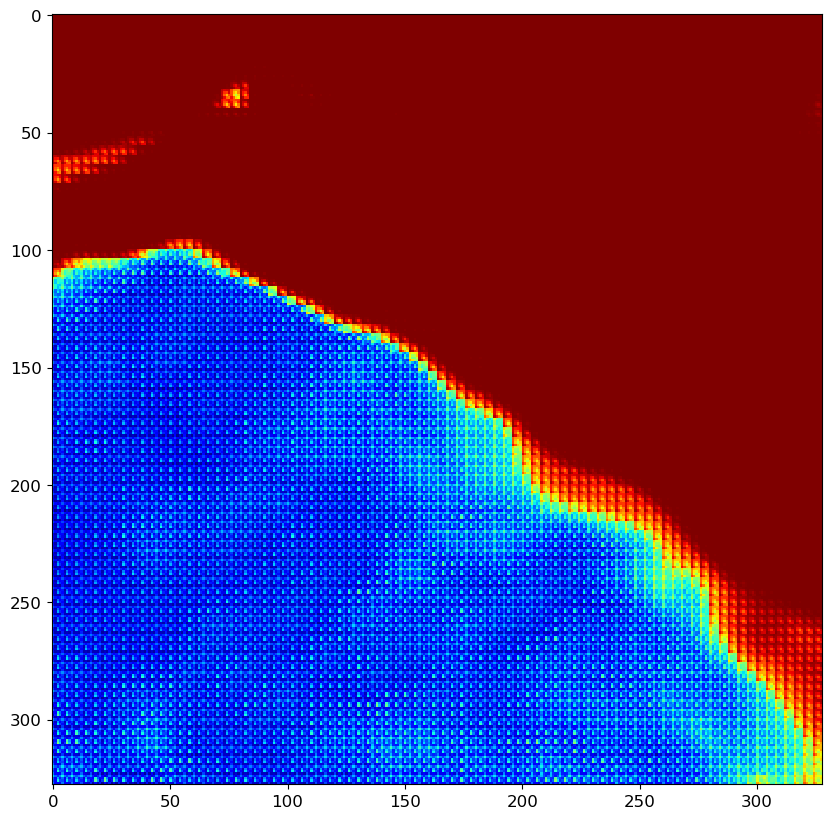

In [3]:
plt.rcParams["figure.figsize"] = (10, 10)
 
import matplotlib.pyplot as plt
plt.imshow(np.absolute(stitched_obj)[0], cmap = 'jet', interpolation='none')

In [ ]:
plt.imshow(np.absolute(obj['probeGuess'])[..., None] * np.absolute(probe.probe_mask))

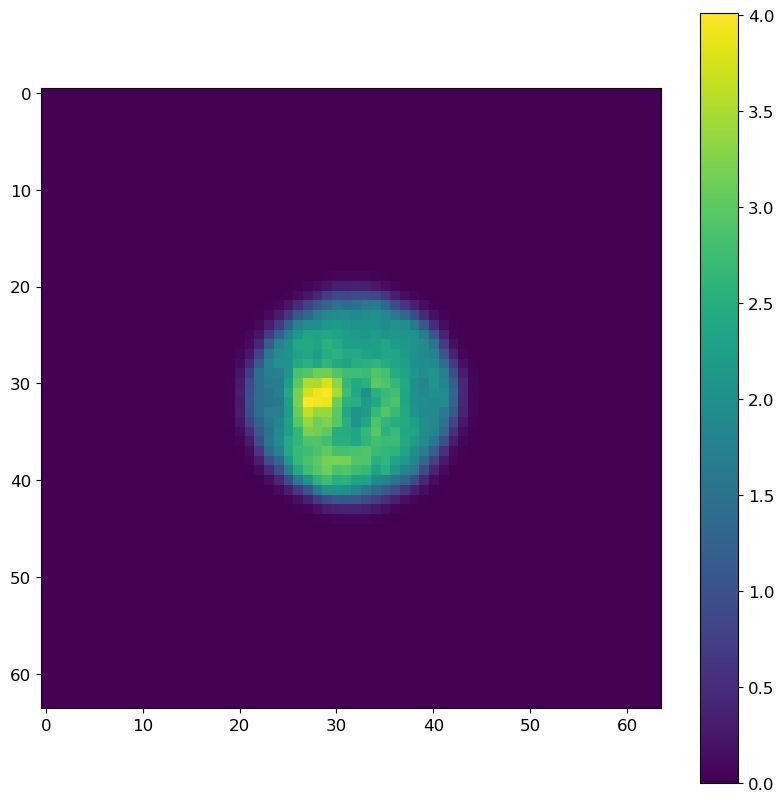

In [3]:
plt.imshow(np.absolute(obj['probeGuess']) * np.absolute(probe.tprobe[:, :, 0]))
plt.colorbar()

In [3]:
coords_nominal.shape

(5120, 1, 2, 4)

In [5]:
diff3d.shape

(1024, 64, 64)

In [3]:
def crop(arr2d, size):
    N, M = arr2d.shape
    return arr2d[(N - size) // 2: -(N - size) // 2, (N - size) // 2: -(N - size) // 2]

global_offsets = xpp.split_tensor(xpp.dset['coords_offsets'])

NameError: name 'xpp' is not defined

In [3]:
i = 300


gt_amp_centered = crop(
    hh.translate(np.angle(obj['objectGuess']), -offsets_2d[i]),
    N // 2)

plt.figure(figsize=(4, 4))  # Adjust the width and height as needed

plt.imshow(gt_amp_centered, cmap = 'jet')
plt.colorbar()

NameError: name 'offsets_2d' is not defined

In [37]:
def crop(arr2d, size):
    N, M = arr2d.shape
    return arr2d[N // 2 - (size) // 2: N // 2+ (size) // 2, N // 2 - (size) // 2: N // 2 + (size) // 2]

def crop12(arr, size):
    N, M = arr.shape[1:3]
    return arr[:, N // 2 - (size) // 2: N // 2+ (size) // 2, N // 2 - (size) // 2: N // 2 + (size) // 2, ...]


import numpy as np

def crop(tensor, size, axes=None):
    # Get the shape of the tensor
    shape = tensor.shape
    
    # Determine the dimensions along which cropping will be applied
    if axes is None:
        axes = tuple(range(len(shape)))
    
    # Create slices for cropping along each specified axis
    slices = []
    for axis in axes:
        axis_size = shape[axis]
        start = axis_size // 2 - size // 2
        end = start + size
        slices.append(slice(max(start, 0), min(end, axis_size)))
    
    # Apply cropping using the slices
    cropped_tensor = tensor[slices]
    return cropped_tensor

def get_gt_patch(offset):
    return crop(
        hh.translate(np.angle(obj['objectGuess']), offset),
        N // 2)

def get_region_gt_patches(test_i):
    relative_xy = tf.squeeze(coords_test_true[test_i])
    res = []
    
    global_offsets = xpp.split_tensor(xpp.dset['coords_offsets'])
    offsets_2d = tf.cast(tf.squeeze(global_offsets), tf.float32)
    offset_shared = offsets_2d[test_i]

    for i in range(relative_xy.shape[-1]):
        offset = offset_shared + tf.cast(relative_xy[:, i], tf.float32)
        patch = get_gt_patch(offset)
        res.append(patch)
    return res

In [6]:
global_offsets = xpp.split_tensor(xpp.dset['coords_offsets'])
gt = np.angle(obj['objectGuess'])

In [5]:
B = X_test.shape[0]

gt_repeat = tf.repeat(
    tf.repeat(gt[None, ...], B, axis = 0)[..., None],
    gridsize**2, axis = 3)

gt_repeat_f = hh._channel_to_flat(gt_repeat)

offsets_c = tf.cast(tf.squeeze(global_offsets + coords_test_true), tf.float32)[:, None, :, :]

offsets_f = hh._channel_to_flat(offsets_c)

gt_translated = hh._flat_to_channel(
    crop12(hh.translate(tf.squeeze(gt_repeat_f)[..., None], tf.squeeze(offsets_f)), N)
)
crop12(gt_translated, N // 2)

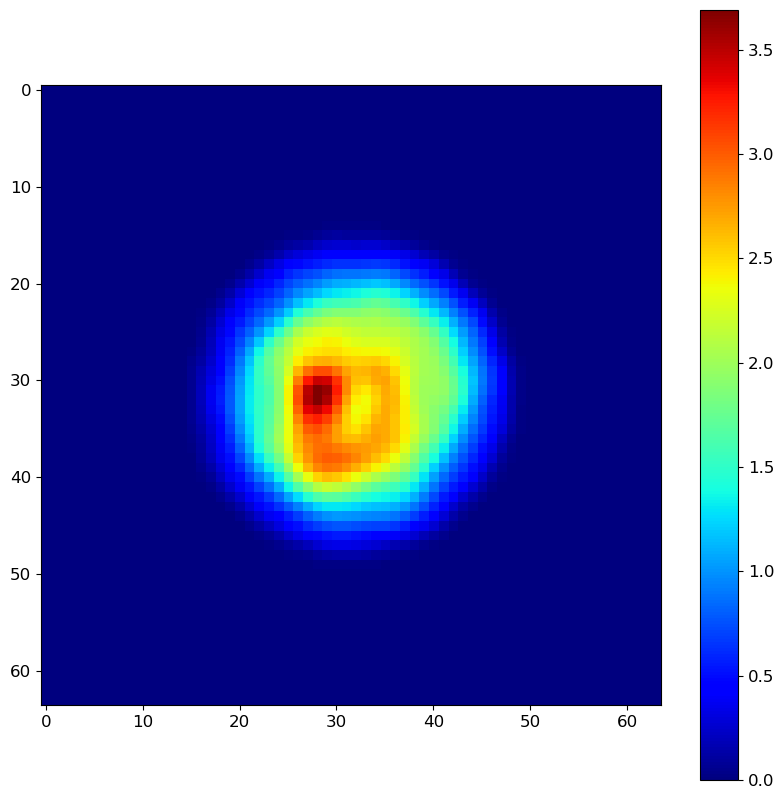

In [4]:
plt.imshow(np.absolute(model.autoencoder.variables[-1]), cmap = 'jet')
plt.colorbar()

phase min: -3.140635 phase max: 3.1405838


/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/evaluation.py:79: RuntimeWarning: divide by zero encountered in log
  true_diffraction = np.log(X_test)[i, :, :, channel]


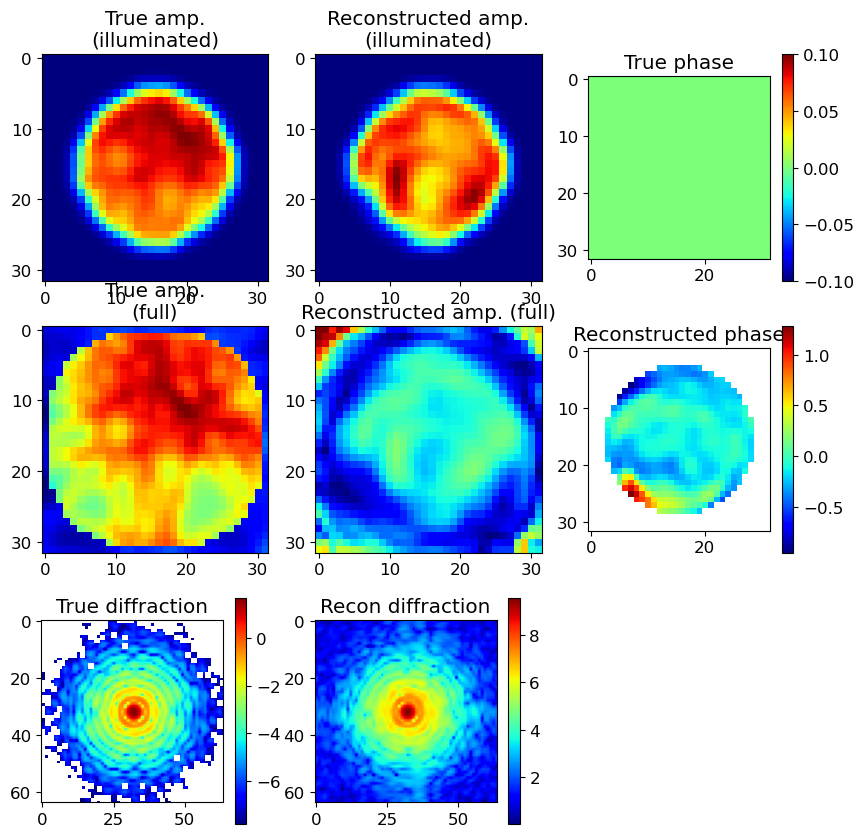

In [4]:
i = 500
from ptycho import evaluation
evaluation.summarize(i, pred_amp + 1, reconstructed_obj, X_test, Y_I_test, Y_phi_test, probe.probe, 2);

phase min: -3.1407025 phase max: 3.1414943


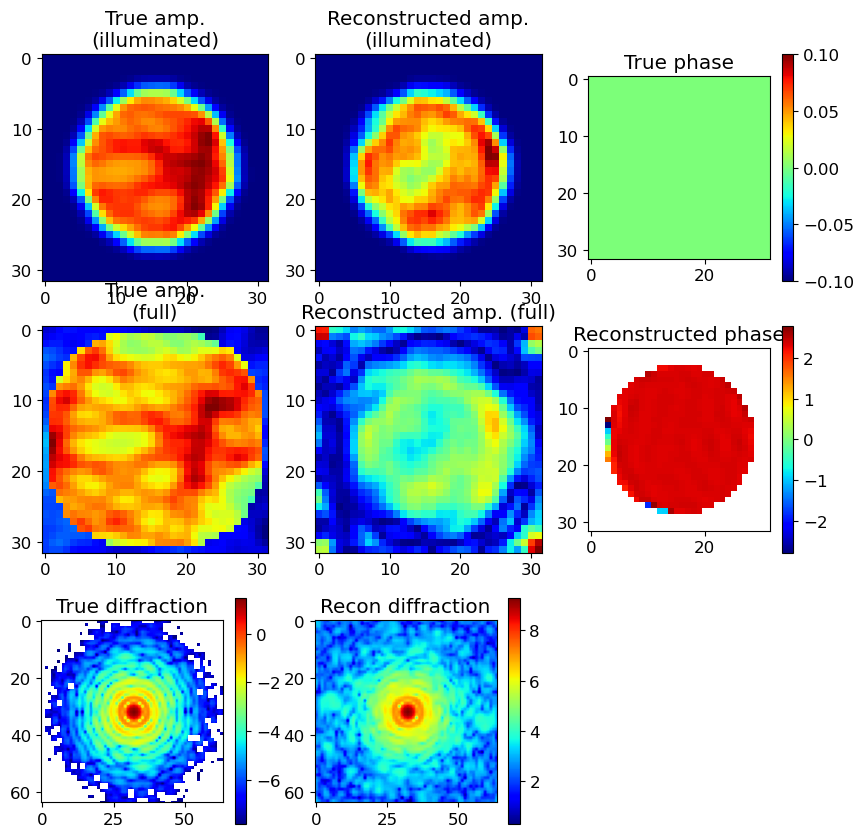

In [9]:
i = 300
from ptycho import evaluation
evaluation.summarize(i, pred_amp + 1, reconstructed_obj, X_test, Y_I_test, Y_phi_test, probe.probe, 2);

phase min: -3.109998 phase max: 3.1082878


/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/evaluation.py:79: RuntimeWarning: divide by zero encountered in log
  true_diffraction = np.log(X_test)[i, :, :, channel]


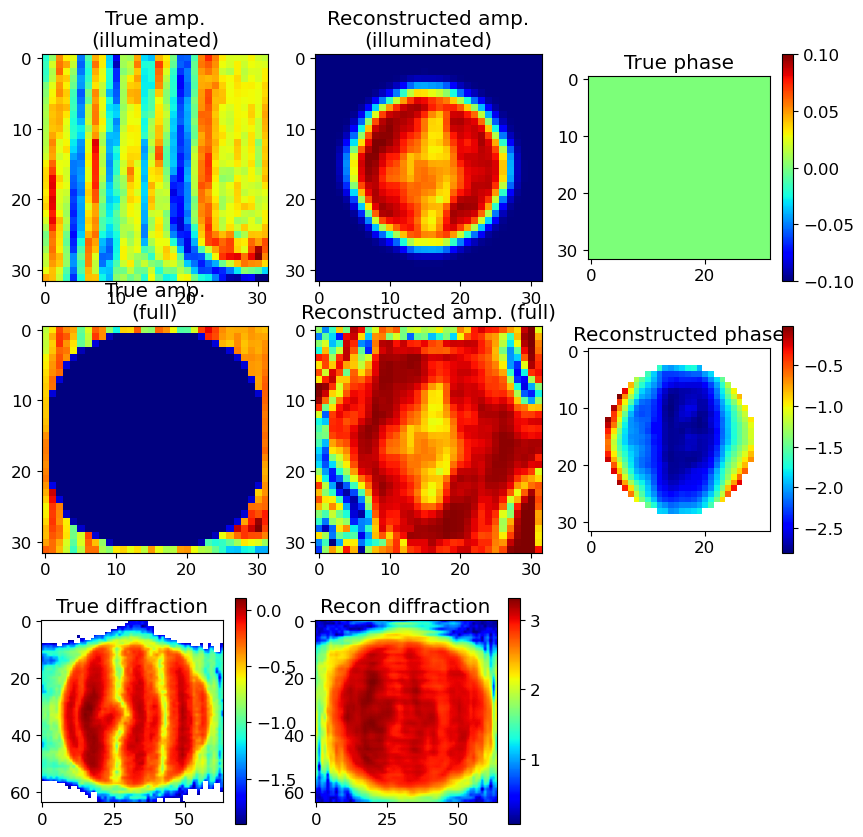

In [3]:
i = 107
from ptycho import evaluation
evaluation.summarize(i, pred_amp + 1, reconstructed_obj, X_test, Y_I_test, Y_phi_test, probe.probe, 0);

In [5]:
dset['coords_nn']

(5120, 1, 2, 4)

phase min: -3.127313 phase max: 3.0976129


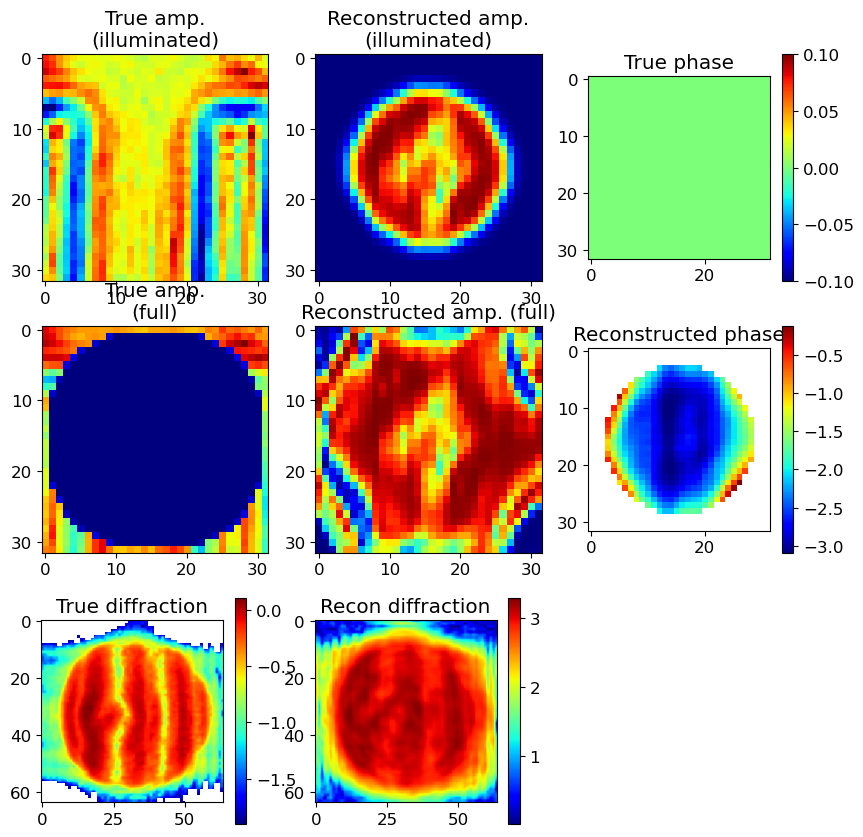

In [11]:
i = 107
from ptycho import evaluation
evaluation.summarize(i, pred_amp + 1, reconstructed_obj, X_test, Y_I_test, Y_phi_test, probe.probe, 0);

phase min: -3.127425 phase max: 2.4710772


/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/evaluation.py:79: RuntimeWarning: divide by zero encountered in log
  true_diffraction = np.log(X_test)[i, :, :, channel]


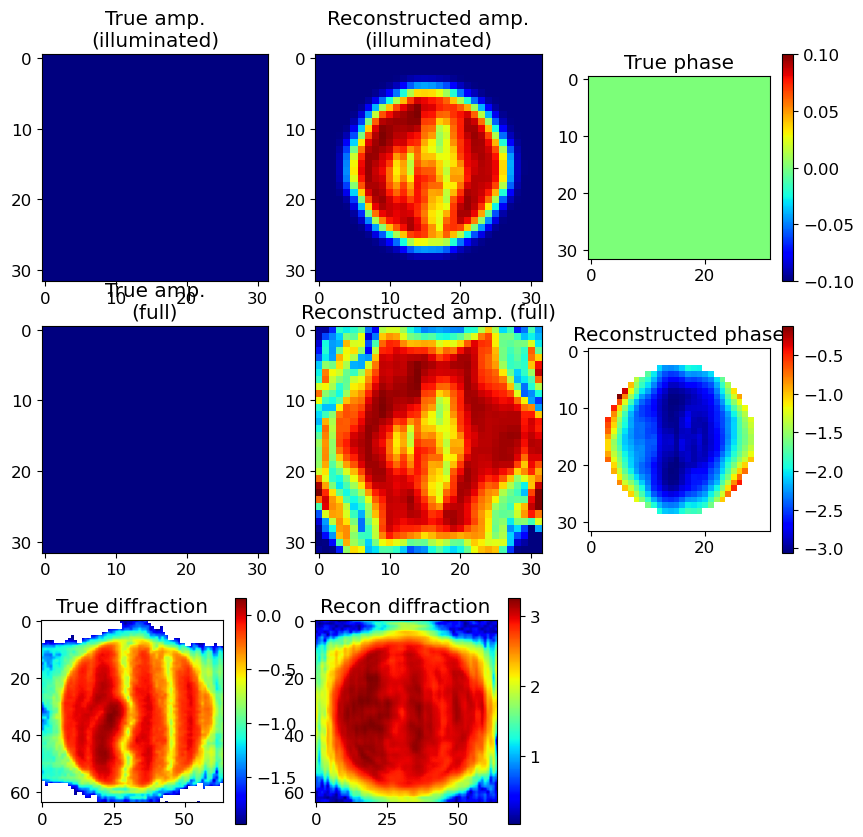

In [3]:
i = 300
from ptycho import evaluation
evaluation.summarize(i, pred_amp + 1, reconstructed_obj, X_test, Y_I_test, Y_phi_test, probe.probe, 0);

phase min: -3.1259022 phase max: 3.029989


/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/evaluation.py:79: RuntimeWarning: divide by zero encountered in log
  true_diffraction = np.log(X_test)[i, :, :, channel]


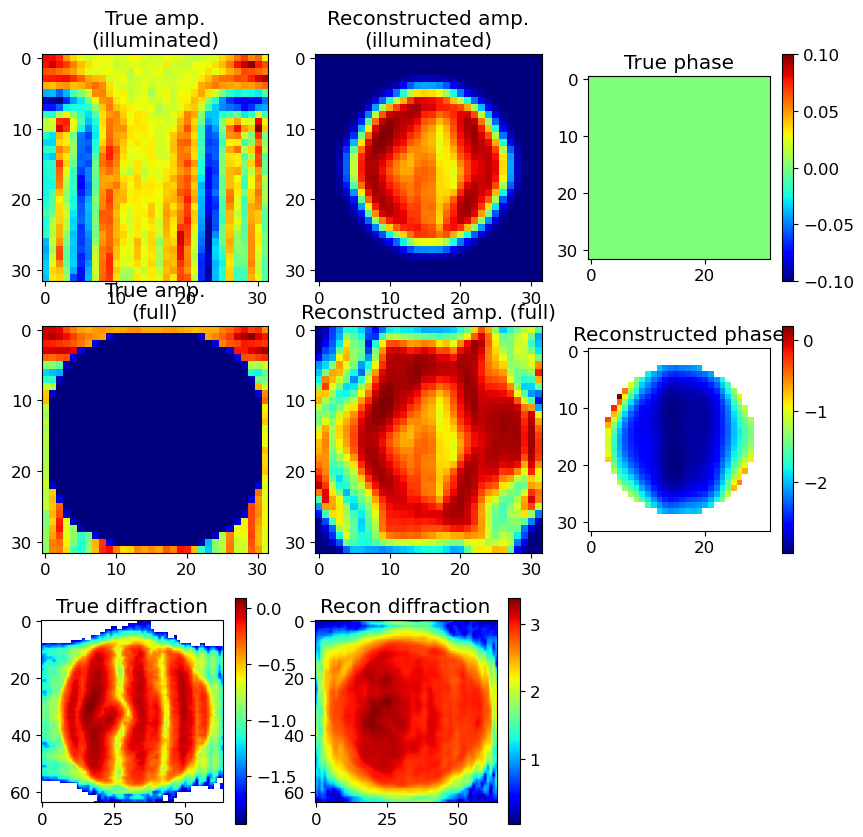

In [5]:
i = 300
from ptycho import evaluation
evaluation.summarize(i, pred_amp + 1, reconstructed_obj, X_test, Y_I_test, Y_phi_test, probe.probe, 2);

phase min: -3.0488467 phase max: 3.077093


/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/evaluation.py:79: RuntimeWarning: divide by zero encountered in log
  true_diffraction = np.log(X_test)[i, :, :, channel]


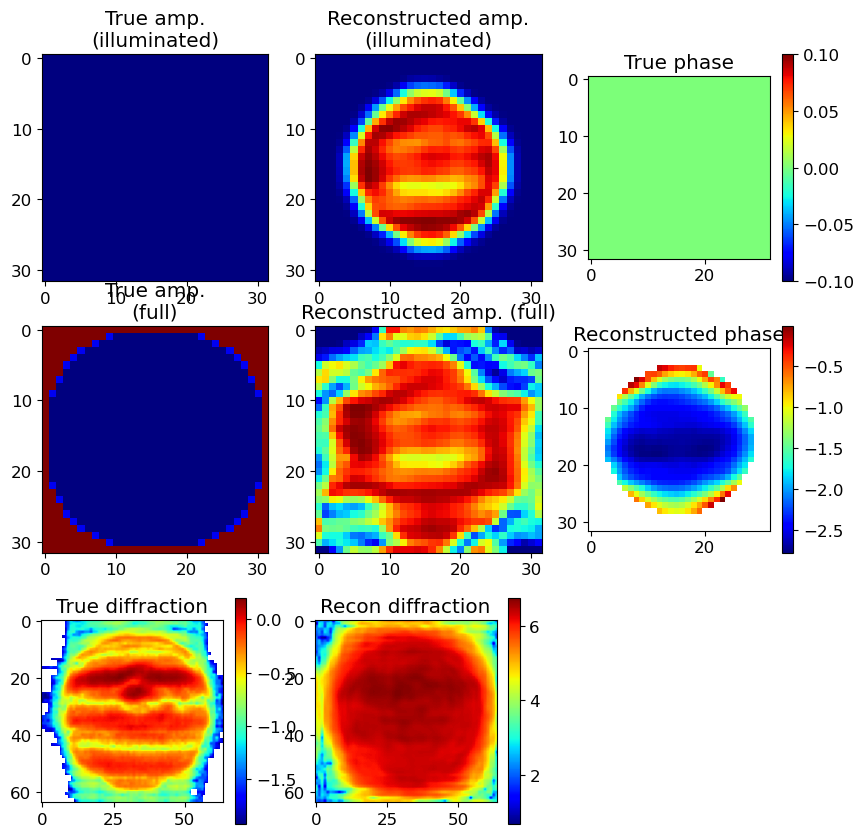

In [4]:
from ptycho import evaluation
i = 300
evaluation.summarize(i, pred_amp + 1, reconstructed_obj, X_test, Y_I_test, Y_phi_test, probe.probe, 0);

phase min: -3.1264403 phase max: 3.126919


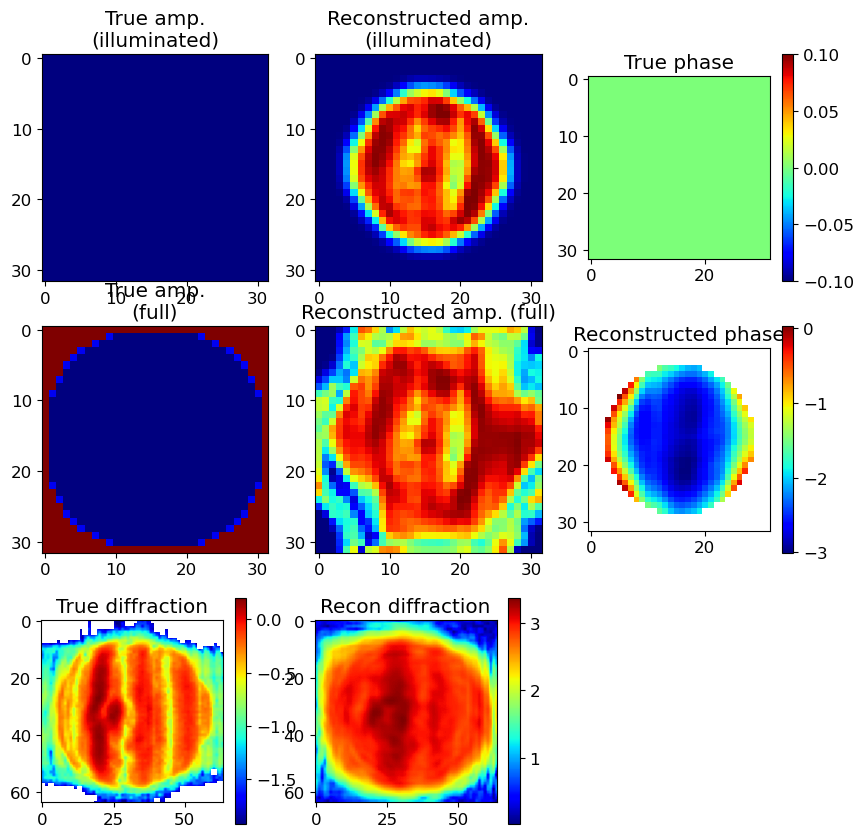

In [5]:
from ptycho import evaluation
i = 300
evaluation.summarize(i, pred_amp + 1, reconstructed_obj, X_test, Y_I_test, Y_phi_test, probe.probe, 0);

phase min: -2.9461477 phase max: 1.7586955


/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/evaluation.py:79: RuntimeWarning: divide by zero encountered in log
  true_diffraction = np.log(X_test)[i, :, :, channel]


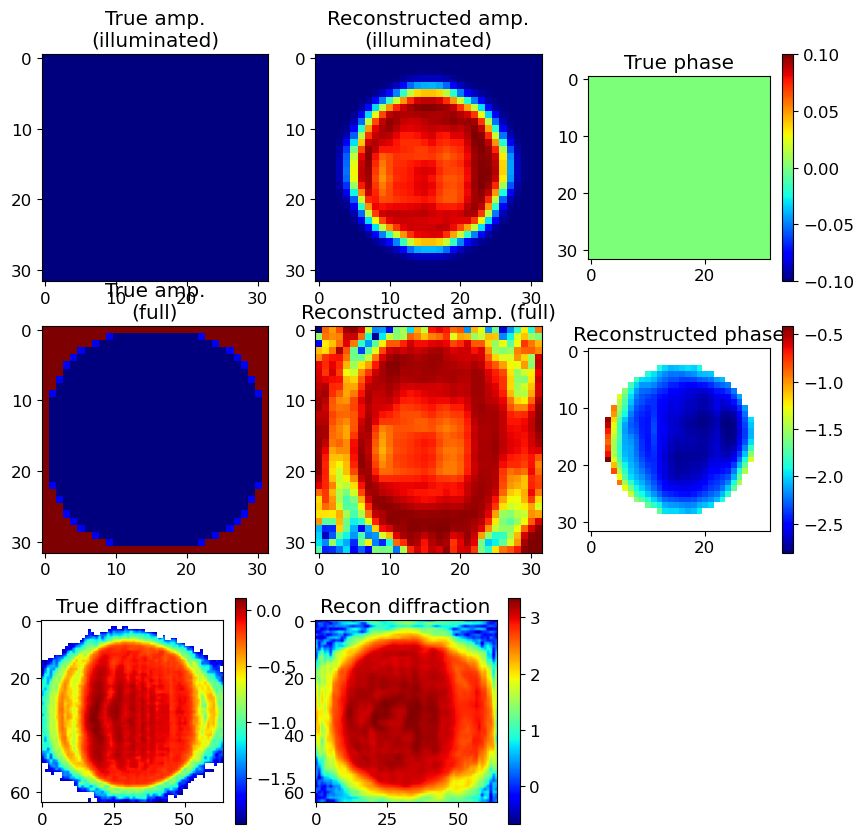

In [4]:
from ptycho import evaluation
i = 300
evaluation.summarize(i, pred_amp + .5, reconstructed_obj, X_test, Y_I_test, Y_phi_test, probe.probe, 0);

phase min: -2.9626362 phase max: 3.0357034


/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/evaluation.py:79: RuntimeWarning: divide by zero encountered in log
  true_diffraction = np.log(X_test)[i, :, :, channel]


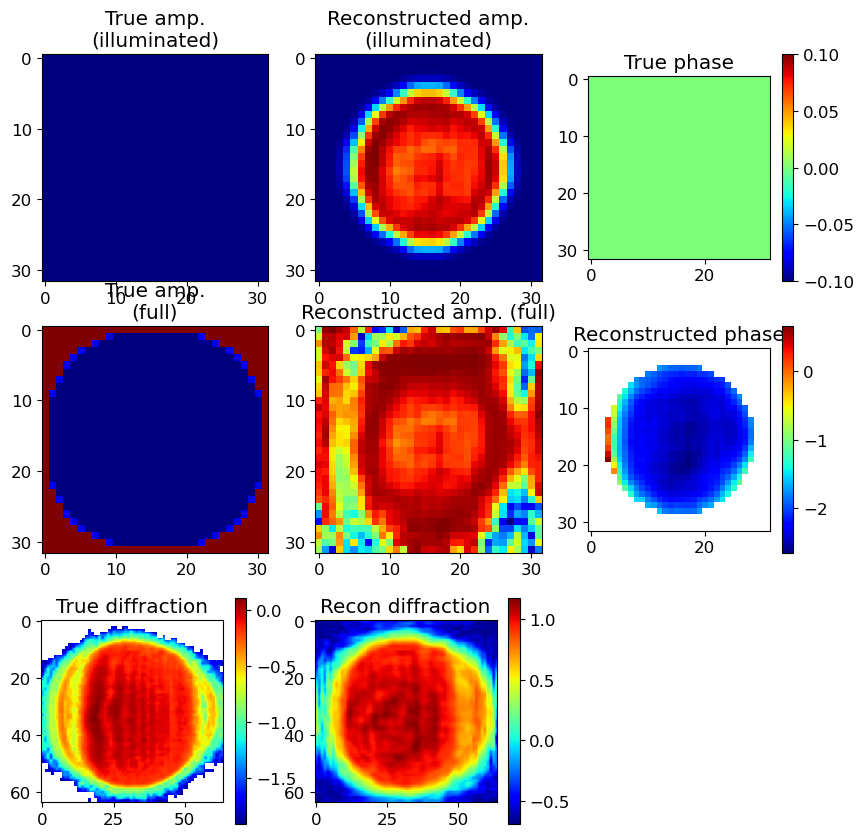

In [4]:
from ptycho import evaluation
i = 300
evaluation.summarize(i, pred_amp + .5, reconstructed_obj, X_test, Y_I_test, Y_phi_test, probe.probe, 0);

phase min: -3.0702643 phase max: 1.6989611


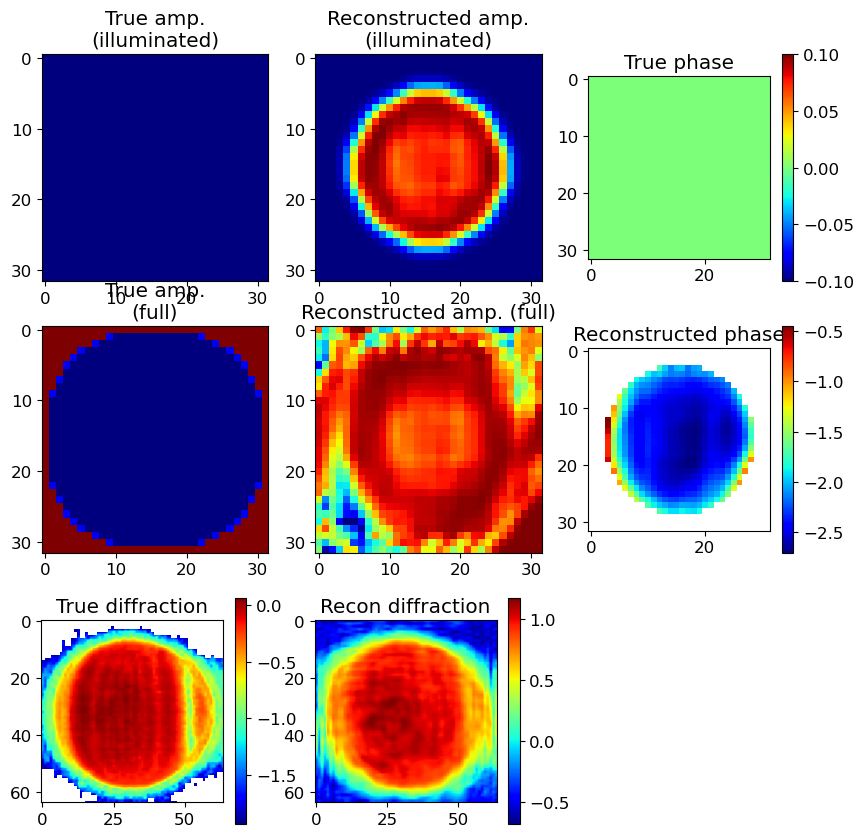

In [9]:
from ptycho import evaluation
i = 300
evaluation.summarize(i, pred_amp + .5, reconstructed_obj, X_test, Y_I_test, Y_phi_test, probe.probe, 2);

phase min: -3.0702643 phase max: 1.6989611


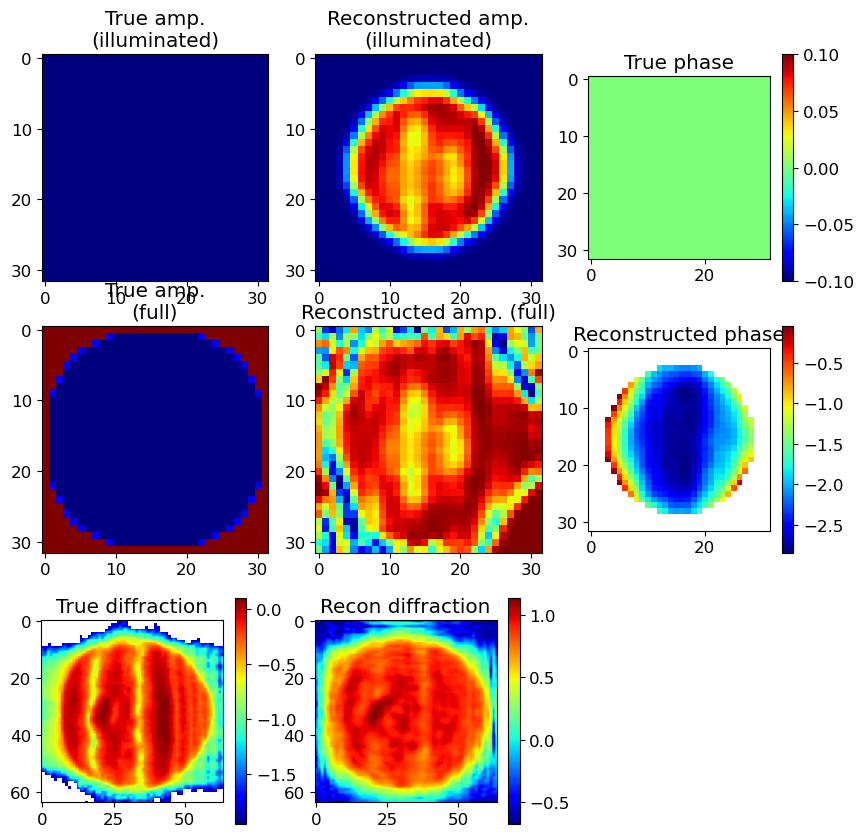

In [5]:
from ptycho import evaluation
i = 100
evaluation.summarize(i, pred_amp + .5, reconstructed_obj, X_test, Y_I_test, Y_phi_test, probe.probe, 2);

phase min: -3.0169663 phase max: 3.0628684


/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/evaluation.py:79: RuntimeWarning: divide by zero encountered in log
  true_diffraction = np.log(X_test)[i, :, :, channel]


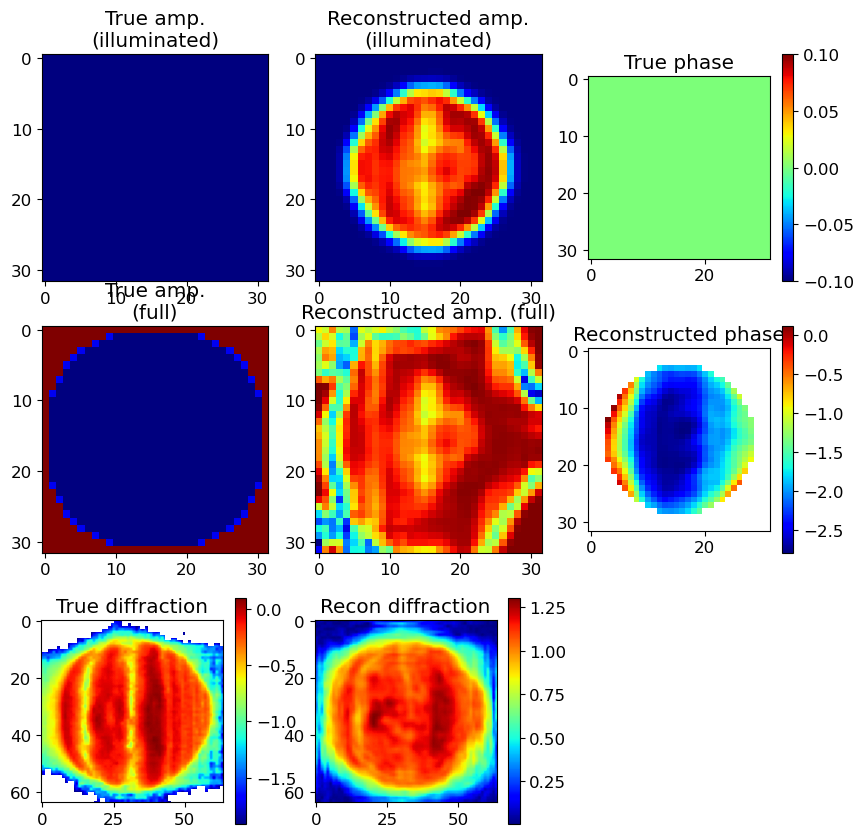

In [6]:
from ptycho import evaluation
i = 100
evaluation.summarize(i, pred_amp + 1, reconstructed_obj, X_test, Y_I_test, Y_phi_test, probe.probe, 2);

phase min: -3.115789 phase max: 1.6128775


/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/evaluation.py:79: RuntimeWarning: divide by zero encountered in log
  true_diffraction = np.log(X_test)[i, :, :, channel]


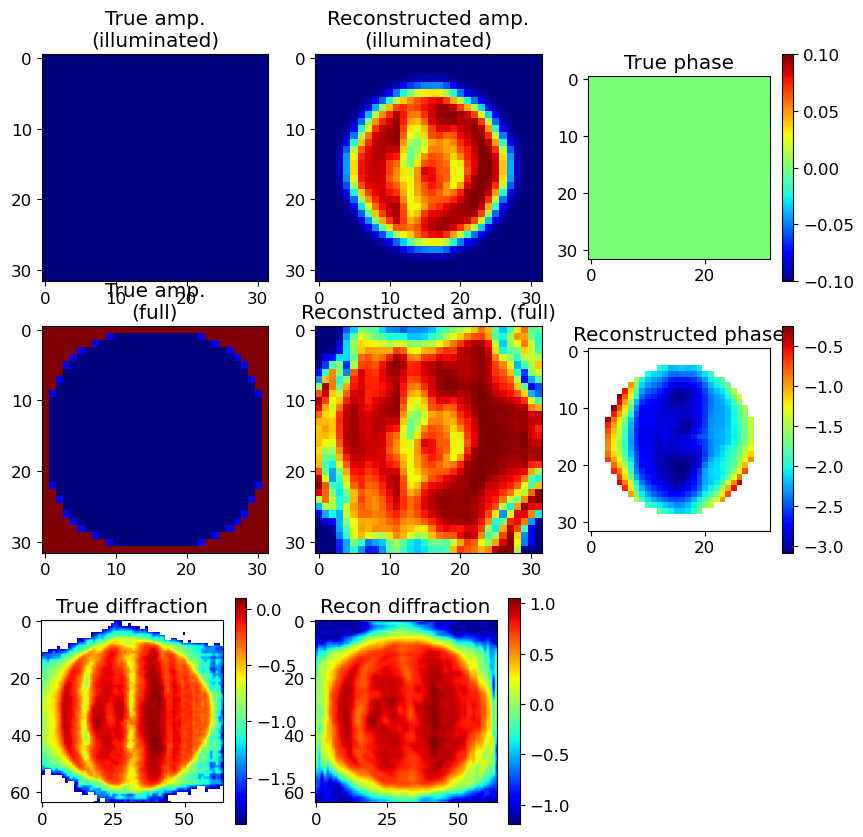

In [5]:
from ptycho import evaluation
i = 100
evaluation.summarize(i, pred_amp + .3, reconstructed_obj, X_test, Y_I_test, Y_phi_test, probe.probe, 0);

In [ ]:
hh.reassemble_nested_average(reconstructed_obj)

In [7]:
reconstructed_obj.shape

(4096, 64, 64, 1)

In [5]:
from ptycho import xpp

In [ ]:
mark

In [6]:
# obj_tensor, _, _, _ = model.autoencoder.predict([X_test * model.params()['intensity_scale'],
#                                                                       coords_test_true])
obj_tensor, _, _, _ = model.autoencoder.predict([X_train * model.params()['intensity_scale'],
                                                                      coords_train_true])

96/96 [==============================] - 5s 52ms/step


In [7]:
global_offsets = xpp.split_tensor(xpp.dset['coords_offsets'], 'test')
offsets_2d = -tf.cast(tf.squeeze(global_offsets), tf.float32)

#offsets_2d = -tf.cast(tf.squeeze(global_offsets), tf.float32)

# global_offsets = tf.transpose(global_offsets, [3, 1, 2, 0], conjugate=False)

In [8]:
global_offsets.shape, offsets_2d.shape

((2048, 1, 2, 1), TensorShape([2048, 2]))

In [35]:
def pnorm():
    M = 10
    canvas_pad = 60
    obj_tensor = reconstructed_obj
    obj_tensor = tf.ones_like(obj_tensor[:, N // 2 - M // 2: N // 2 + M // 2, N // 2 - M // 2: N // 2 + M // 2, :])
    obj_tensor = hh.pad(obj_tensor, canvas_pad)

    obj_translated = hh.translate(obj_tensor, offsets_2d, interpolation = 'bilinear')

    obj_pos_reassembeled = tf.reduce_sum(obj_translated, 0)
    return obj_pos_reassembeled

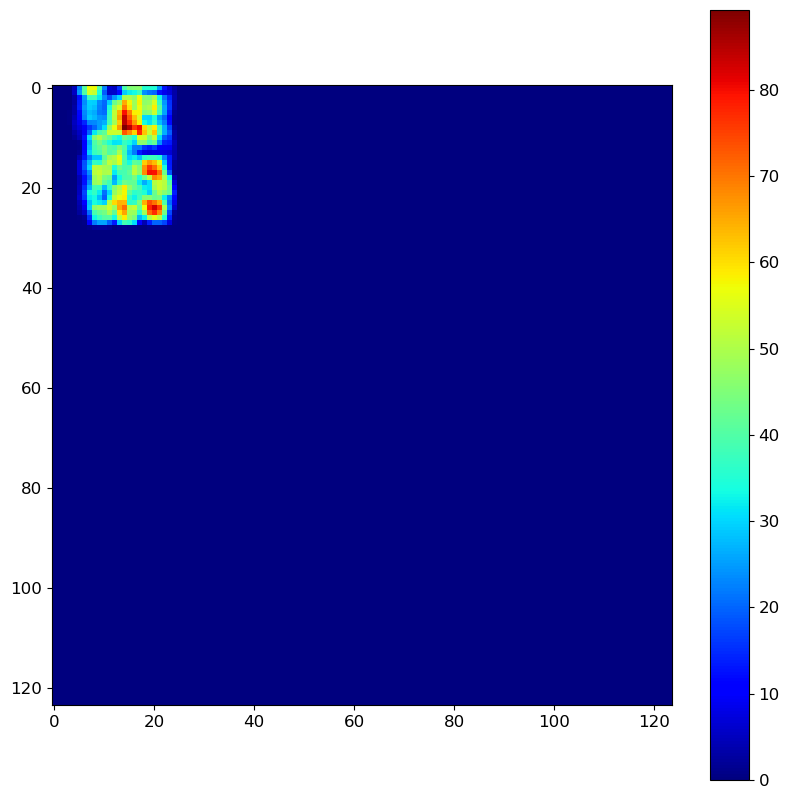

In [27]:
plt.imshow(np.absolute(pnorm()), cmap = 'jet')
plt.colorbar()

In [36]:
M = 10
canvas_pad = 60
obj_tensor = reconstructed_obj
obj_tensor = obj_tensor[:, N // 2 - M // 2: N // 2 + M // 2, N // 2 - M // 2: N // 2 + M // 2, :]
obj_tensor = hh.pad(obj_tensor, canvas_pad)

obj_translated = hh.translate(obj_tensor, offsets_2d, interpolation = 'bilinear')

obj_pos_reassembeled = tf.reduce_sum(obj_translated, 0)

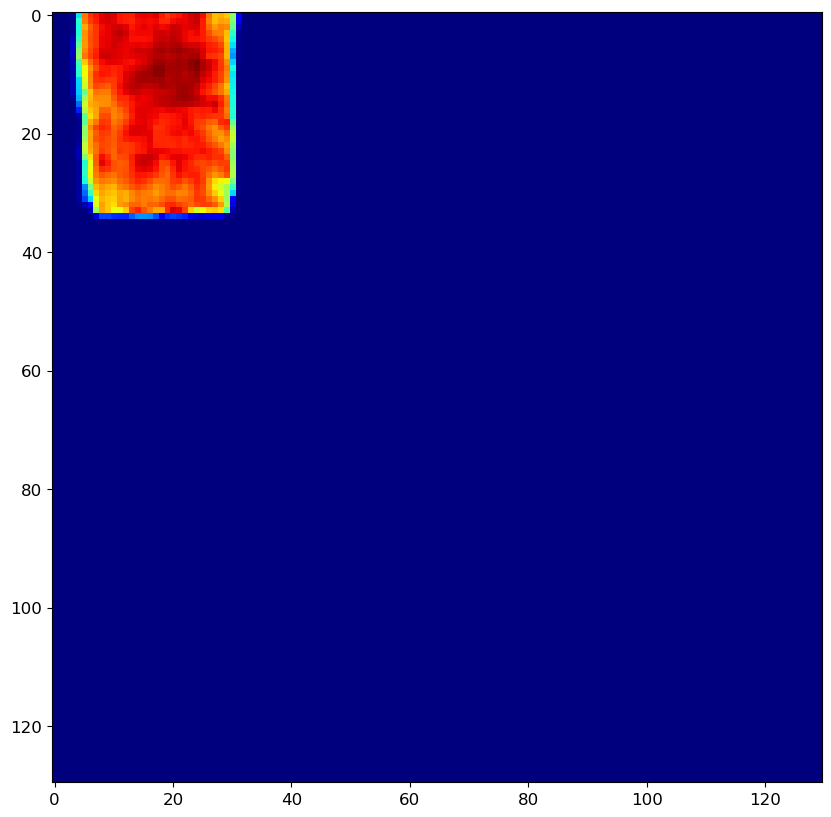

In [37]:
plt.imshow(np.absolute(obj_pos_reassembeled) / (10 + np.absolute(pnorm())), cmap = 'jet')

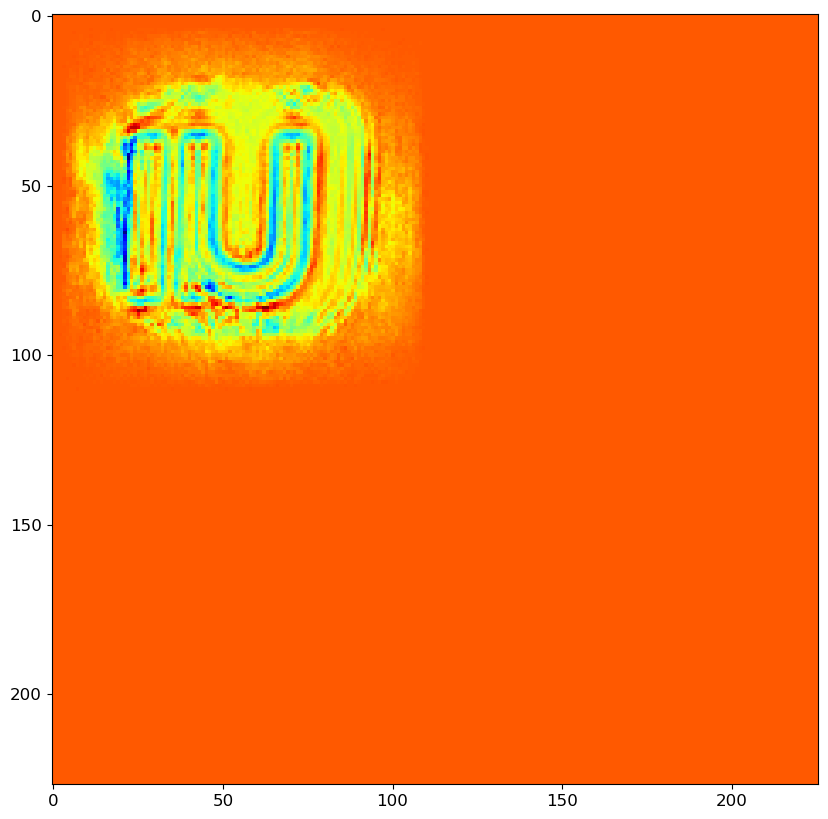

In [60]:
plt.imshow(np.absolute(obj['objectGuess']), cmap = 'jet')

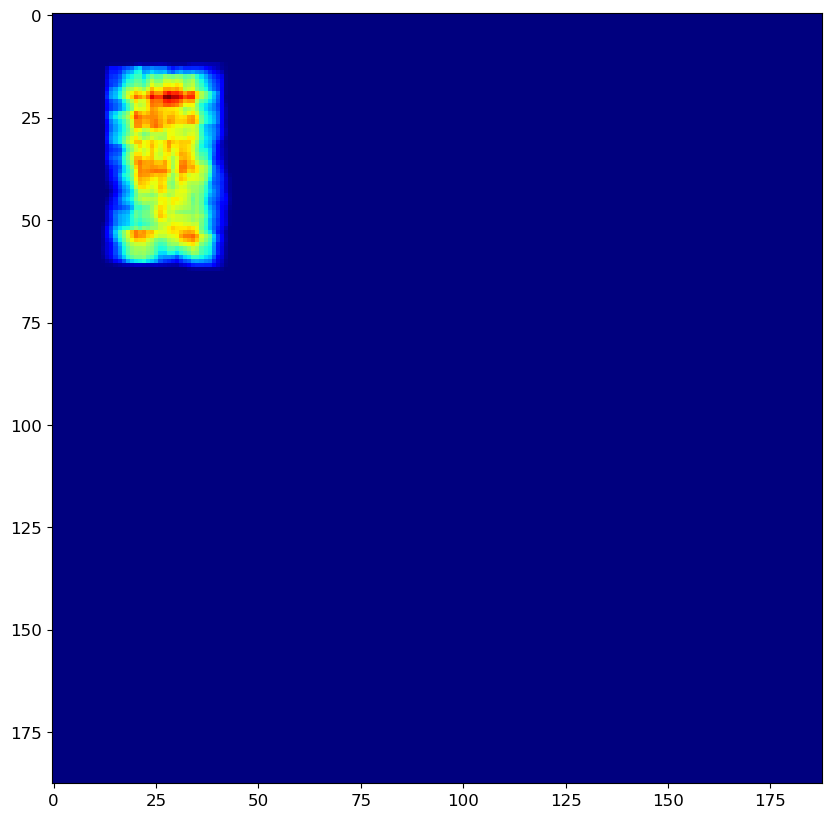

In [61]:
plt.imshow(np.absolute(obj_pos_reassembeled), cmap = 'jet')

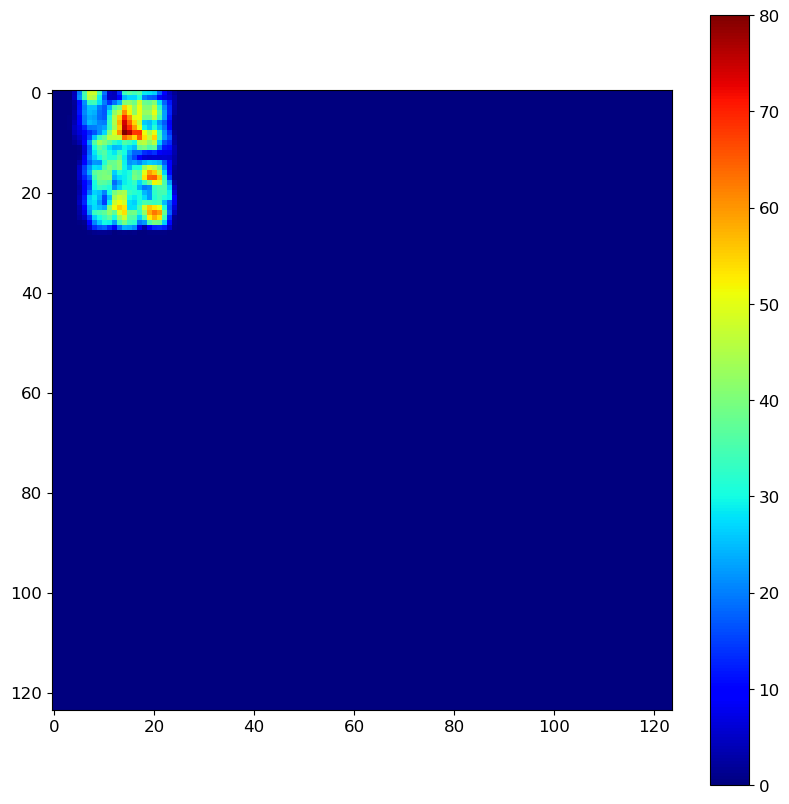

In [26]:
plt.imshow(np.absolute(obj_pos_reassembeled), cmap = 'jet')
plt.colorbar()

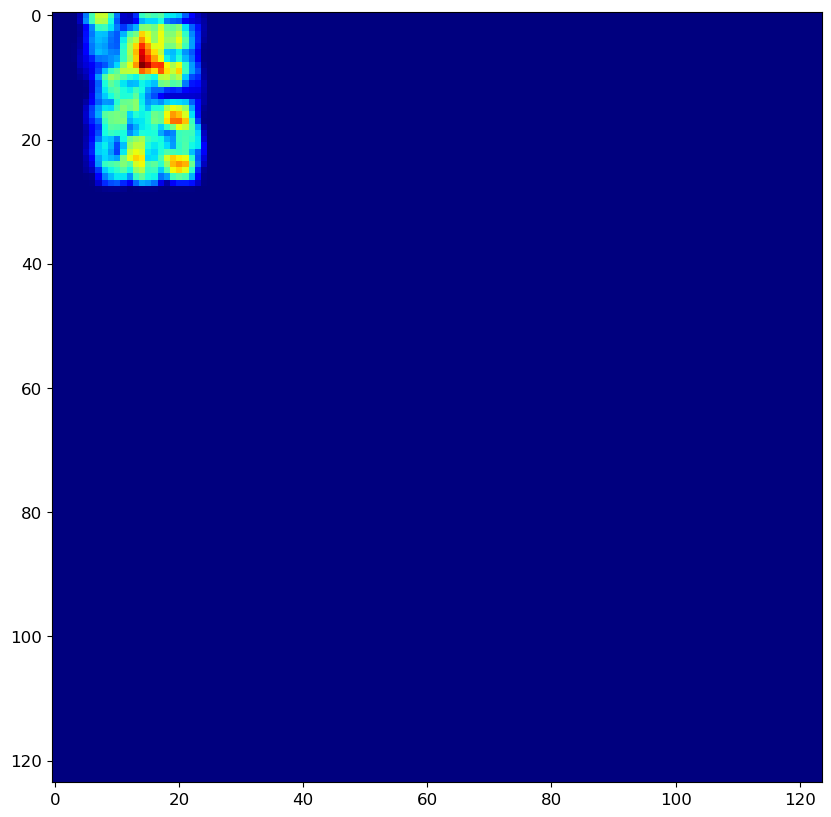

In [75]:
plt.imshow(np.absolute(obj_pos_reassembeled), cmap = 'jet')

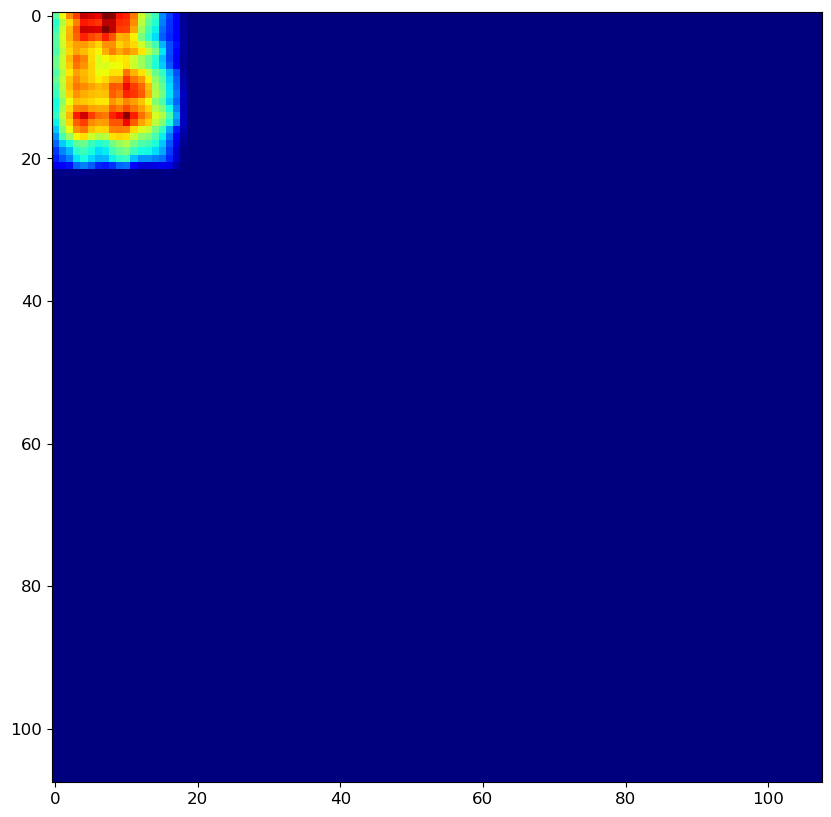

In [44]:
plt.imshow(np.absolute(obj_pos_reassembeled), cmap = 'jet')

In [32]:
offsets_2d[0]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-55.843906, -55.19216 ], dtype=float32)>

In [45]:


global_offsets = xpp.split_tensor(xpp.dset['coords_offsets'])
offsets_2d = -tf.cast(tf.squeeze(global_offsets), tf.float32)

gt_amp_centered = hh.translate(np.absolute(obj['objectGuess']), -offsets_2d[0])

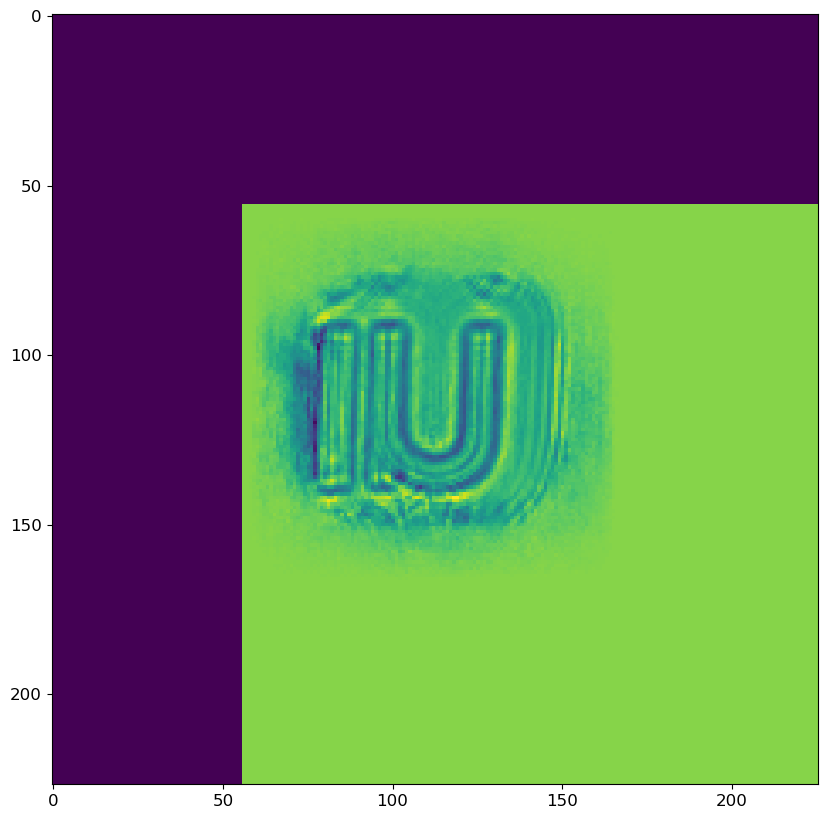

In [44]:
plt.imshow()

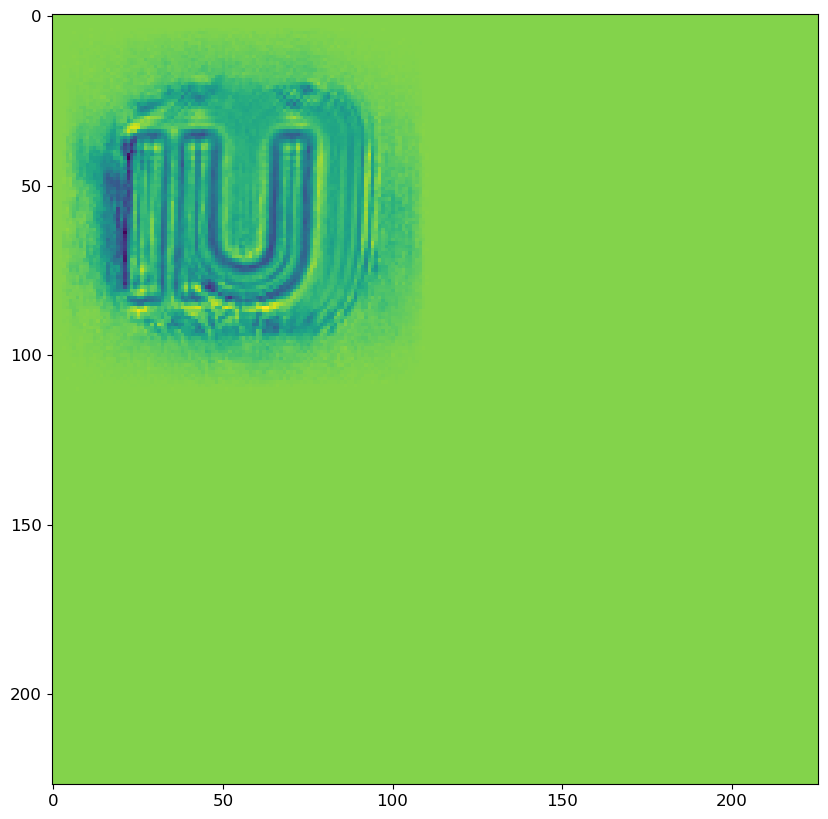

In [28]:
plt.imshow(np.absolute(obj['objectGuess']))

In [28]:
global_offsets

<tf.Tensor: shape=(1, 1, 2, 10240), dtype=float64, numpy=
array([[[[38.15054693, 37.96184123, 37.62139586, ..., 62.3902557 ,
          61.85825183, 62.30794668],
         [77.00771349, 77.44443573, 77.43871922, ..., 39.30035574,
          39.08144158, 39.24480746]]]])>

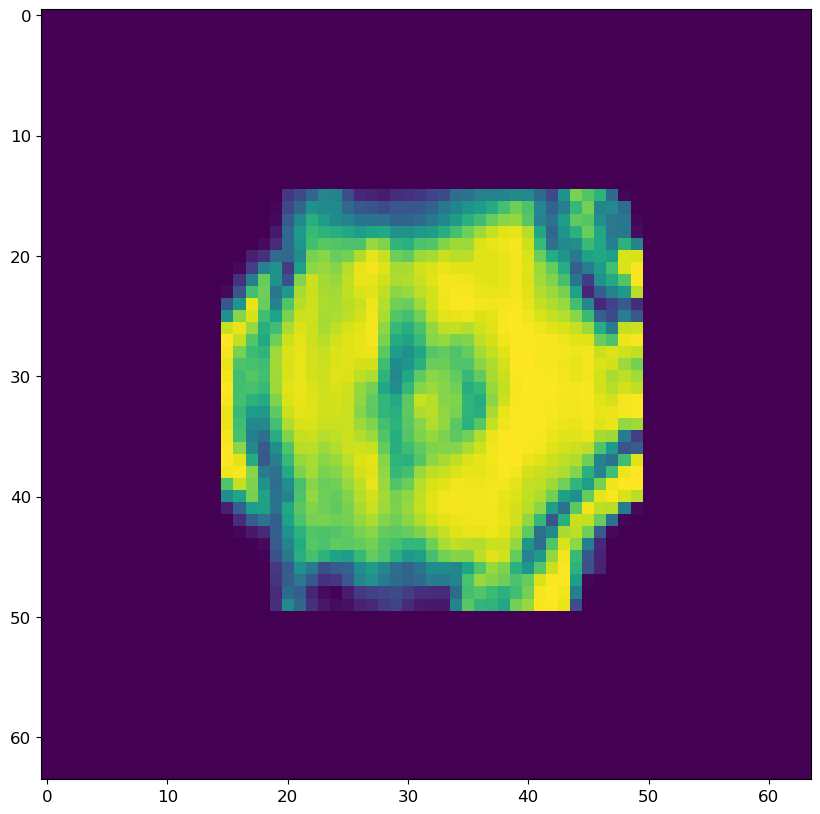

In [10]:
plt.imshow(np.absolute(reconstructed_obj[100]))

phase min: -3.1110606 phase max: 3.1137784


/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/evaluation.py:79: RuntimeWarning: divide by zero encountered in log
  true_diffraction = np.log(X_test)[i, :, :, channel]


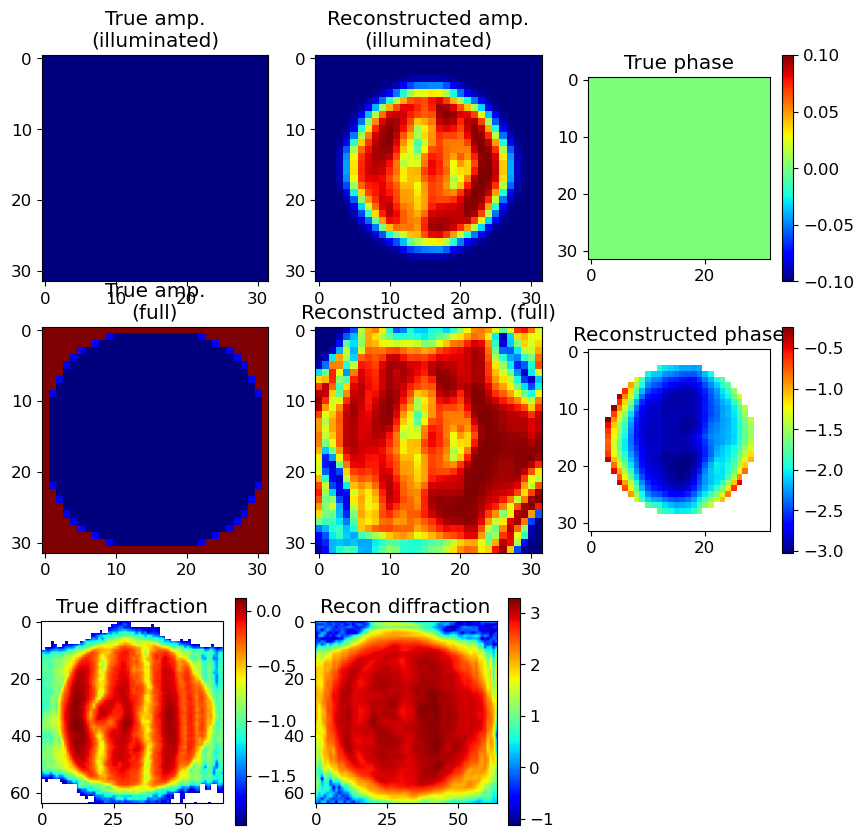

In [5]:
from ptycho import evaluation
i = 100
evaluation.summarize(i, pred_amp + .3, reconstructed_obj, X_test, Y_I_test, Y_phi_test, probe.probe, 0);

In [4]:
from ptycho.xpp import *

In [5]:
pred_amp[100, :, :, 0].mean()

0.7018459

In [6]:
np.absolute(pred_amp).mean()

0.7197135

In [7]:
np.absolute(reconstructed_obj).mean()

0.23019366

In [8]:
from ptycho import model

from ptycho import generate_data as init

In [10]:
probe.set_probe_guess(None, obj['probeGuess']).shape

TensorShape([64, 64, 1])

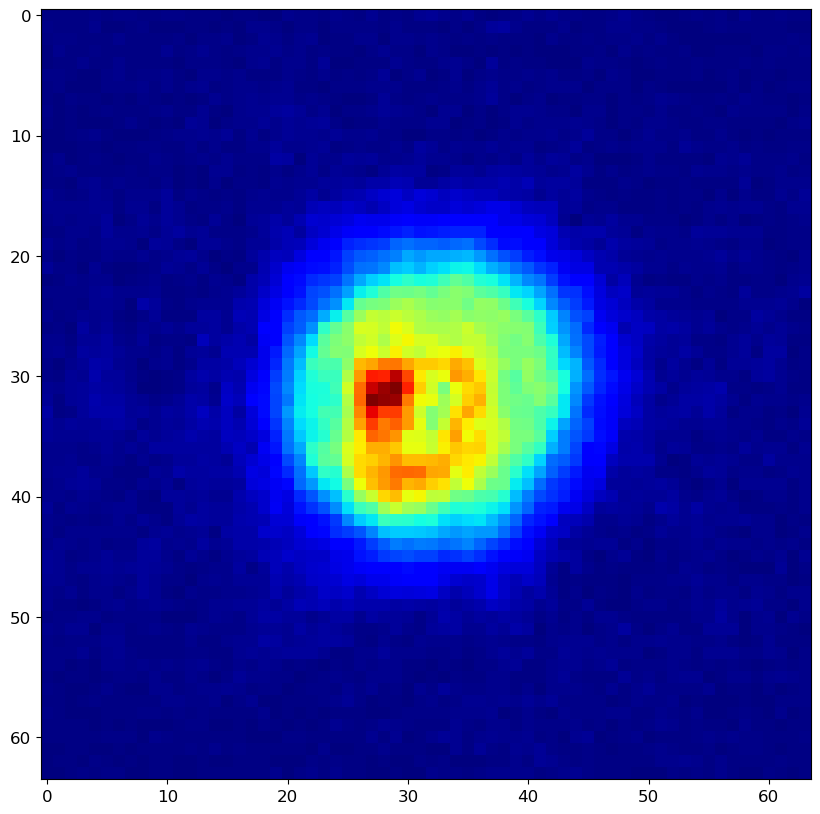

In [7]:
plt.imshow(np.absolute(tf.cast(obj['probeGuess'], tf.complex64)), cmap = 'jet')

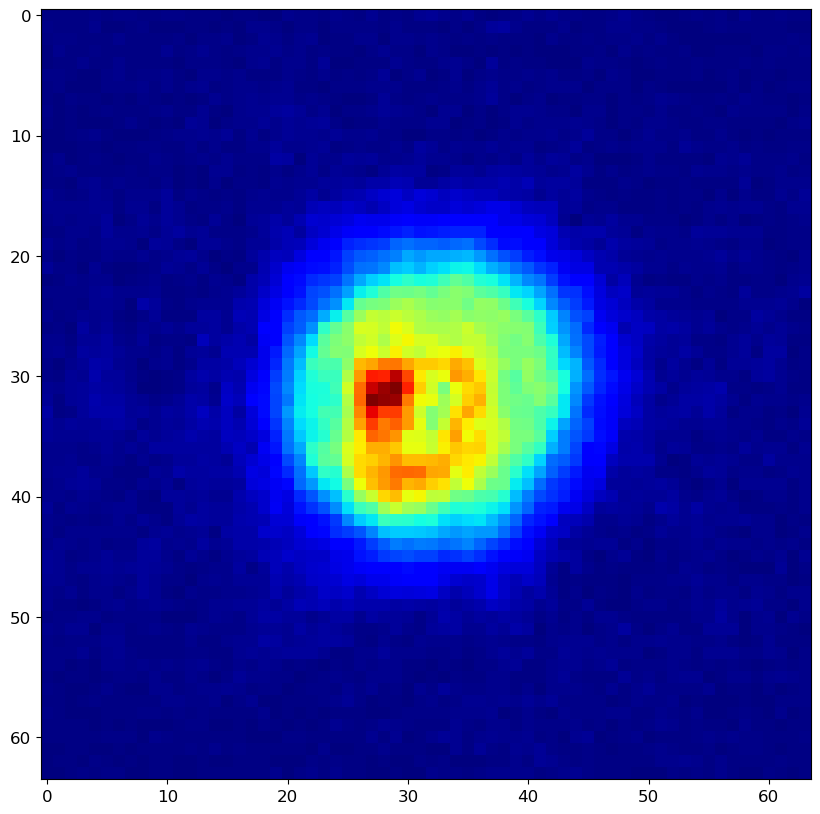

In [12]:
plt.imshow(np.absolute(obj['probeGuess']), cmap = 'jet')

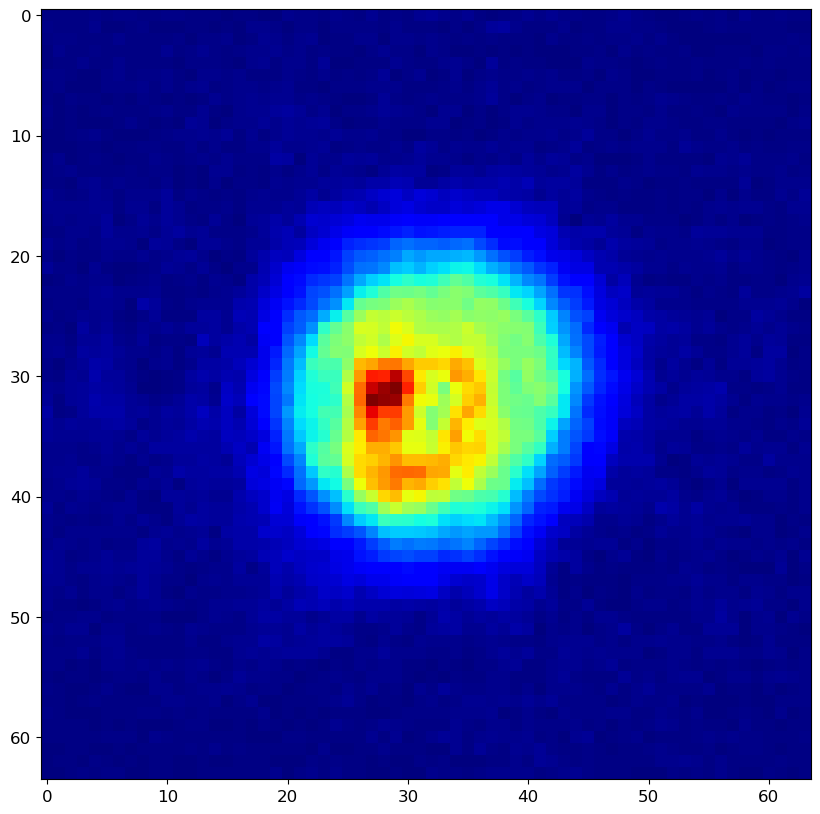

In [13]:
from ptycho import params as p
plt.imshow(np.absolute(p.get('probe')), cmap = 'jet')

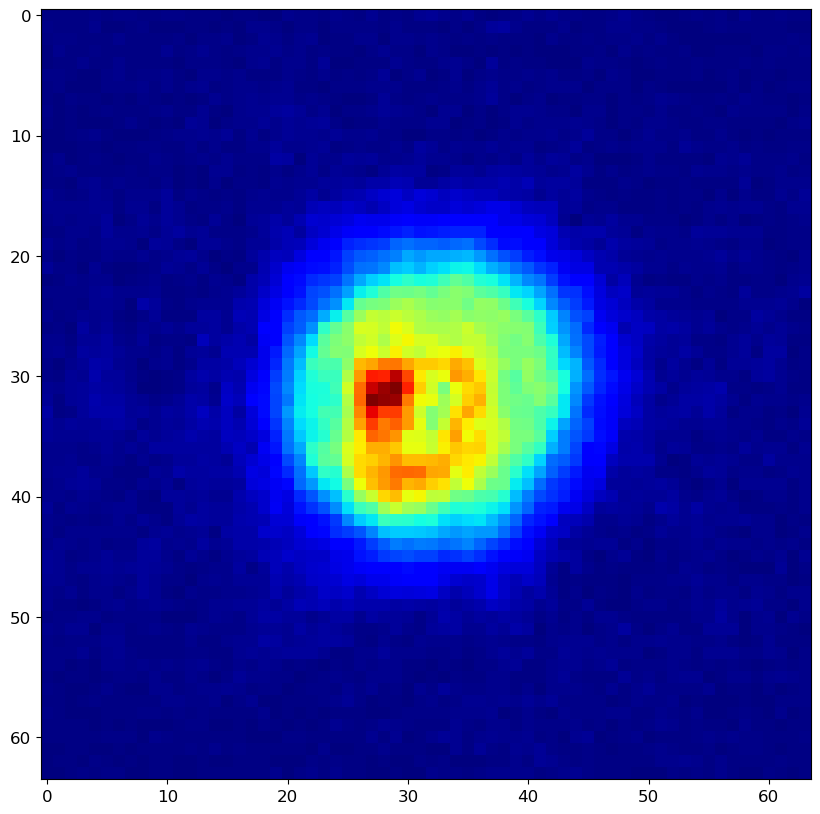

In [8]:
plt.imshow(np.absolute(model.autoencoder.variables[-1]), cmap = 'jet')


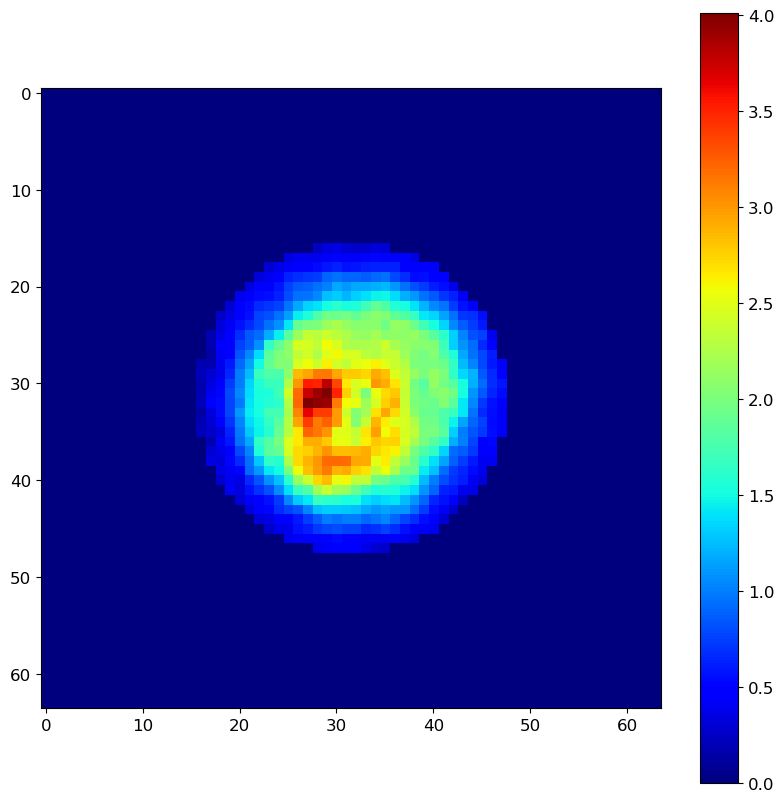

In [10]:
plt.imshow(np.absolute(model.autoencoder.variables[-1]) * probe.probe_mask_real, cmap = 'jet')
plt.colorbar()

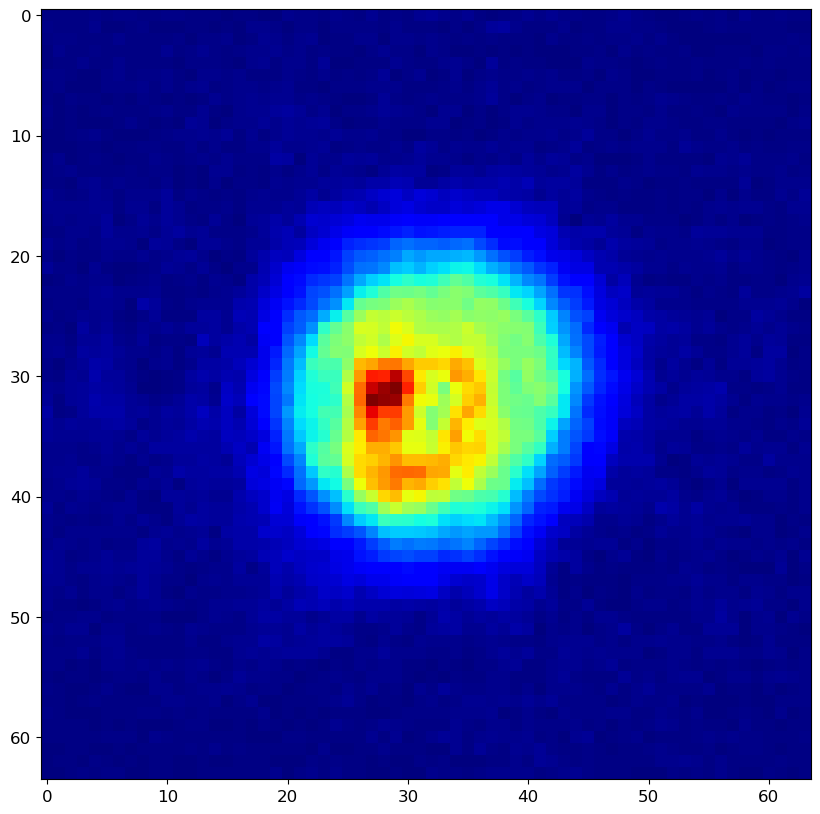

In [8]:
plt.imshow(np.absolute(obj['probeGuess']), cmap = 'jet')

In [15]:
from importlib import reload

In [16]:
reload(evaluation)

<module 'ptycho.evaluation' from '/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/evaluation.py'>

phase min: -3.013871 phase max: 3.0893202


/home/ollie/Documents/scratch/ptycho/notebooks/ptycho/evaluation.py:79: RuntimeWarning: divide by zero encountered in log
  true_diffraction = np.log(X_test)[i, :, :, channel]


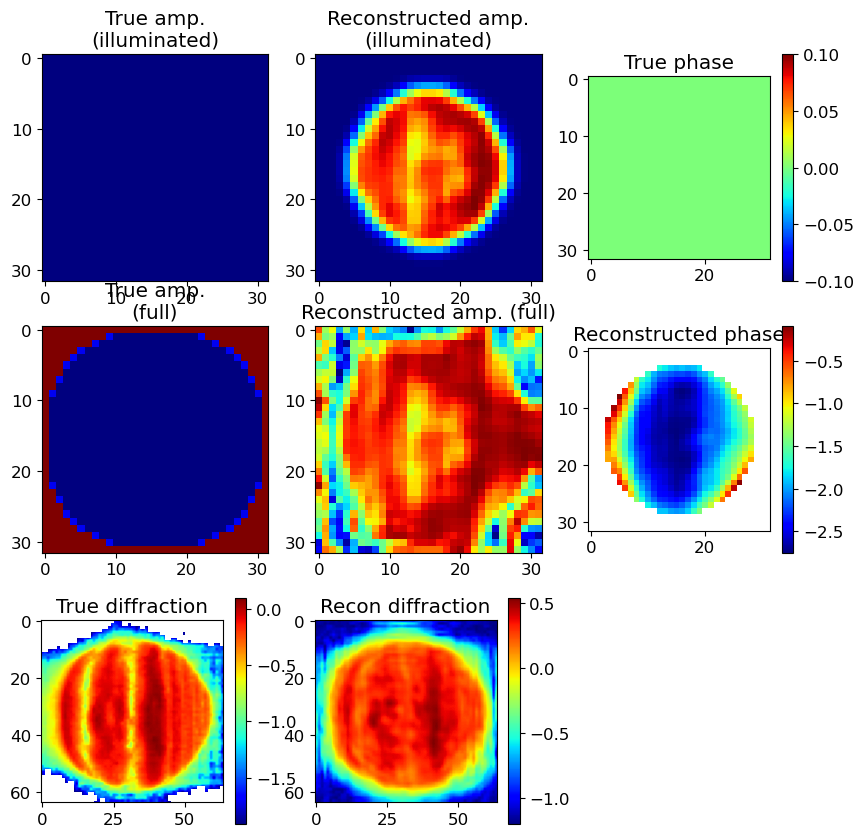

In [11]:
from ptycho import evaluation
i = 100
evaluation.summarize(i, pred_amp + .3, reconstructed_obj, X_test, Y_I_test, Y_phi_test, probe.probe, 0);

phase min: -3.1393626 phase max: 3.0823731


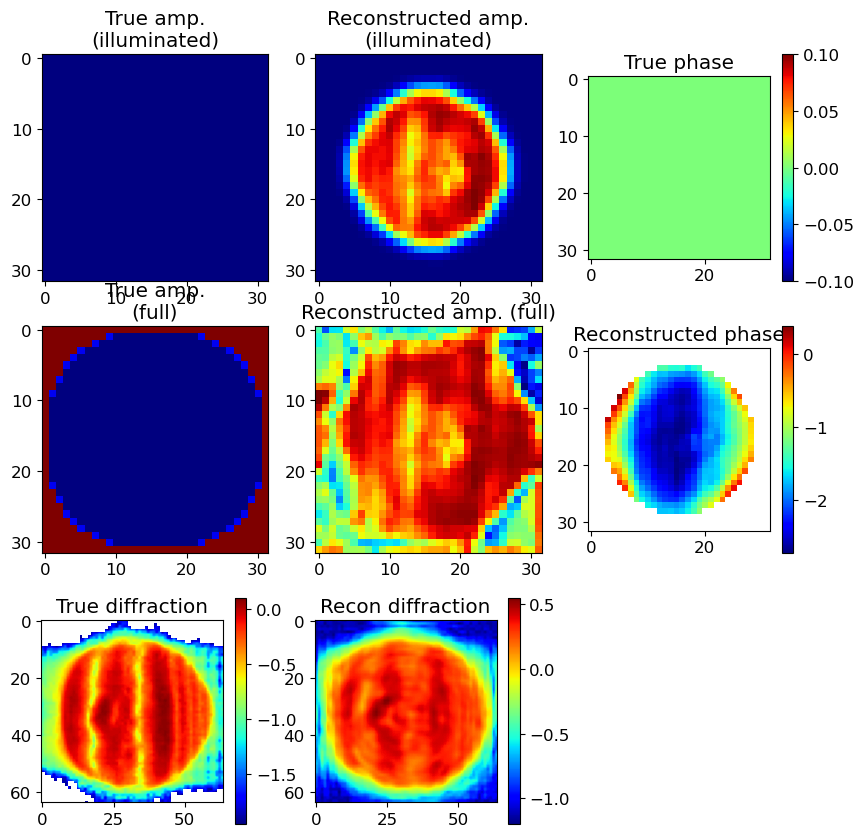

In [18]:
from ptycho import evaluation
i = 100
evaluation.summarize(i, pred_amp + .3, reconstructed_obj, X_test, Y_I_test, Y_phi_test, probe.probe, 0);

phase min: -3.1393626 phase max: 3.0823731


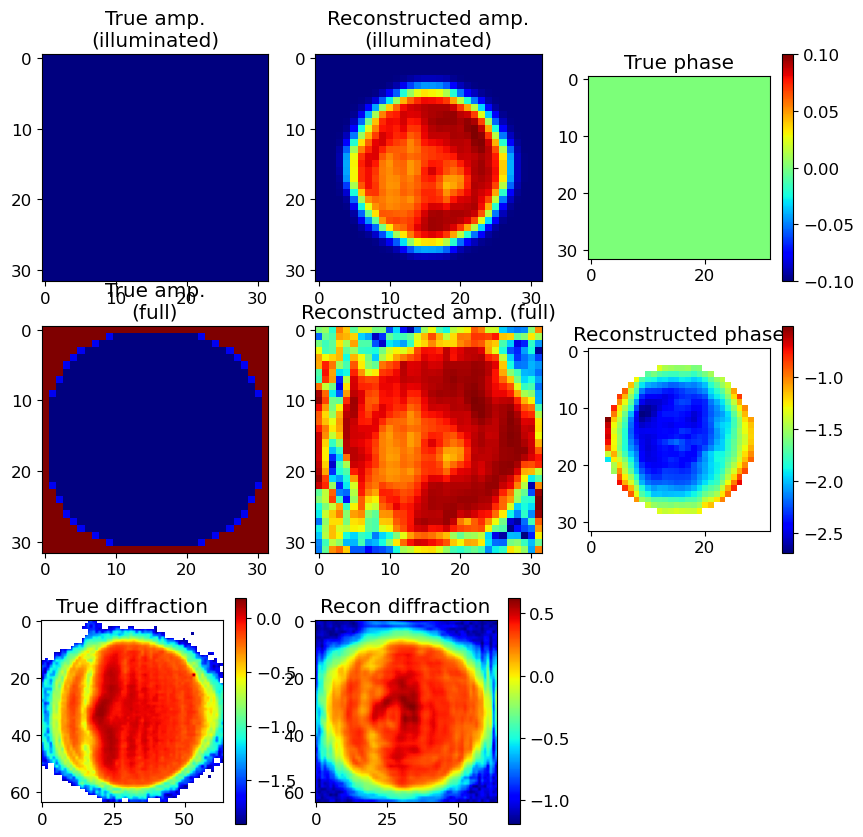

In [17]:
from ptycho import evaluation
i = 1000
evaluation.summarize(i, pred_amp + .3, reconstructed_obj, X_test, Y_I_test, Y_phi_test, probe.probe, 0);

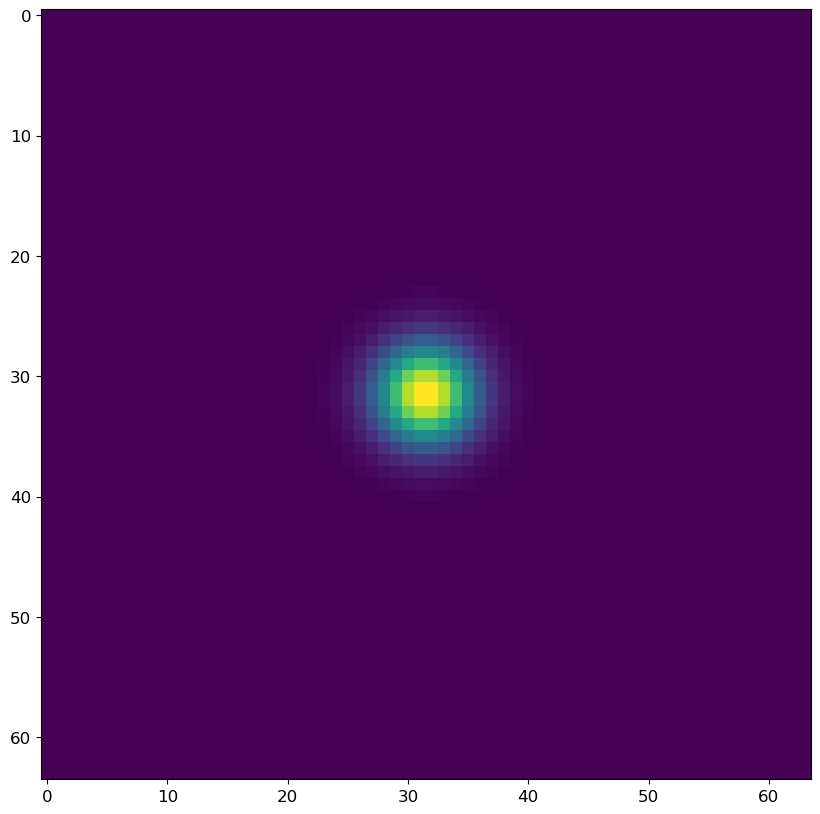

In [24]:
plt.imshow(np.absolute(model.initial_probe_guess))

In [11]:
reconstructed_obj.shape

(424, 64, 64, 1)

In [5]:
from ptycho import datasets

(64, 64)

In [13]:
np.absolute(coords_relative).mean()

1.255082844457051

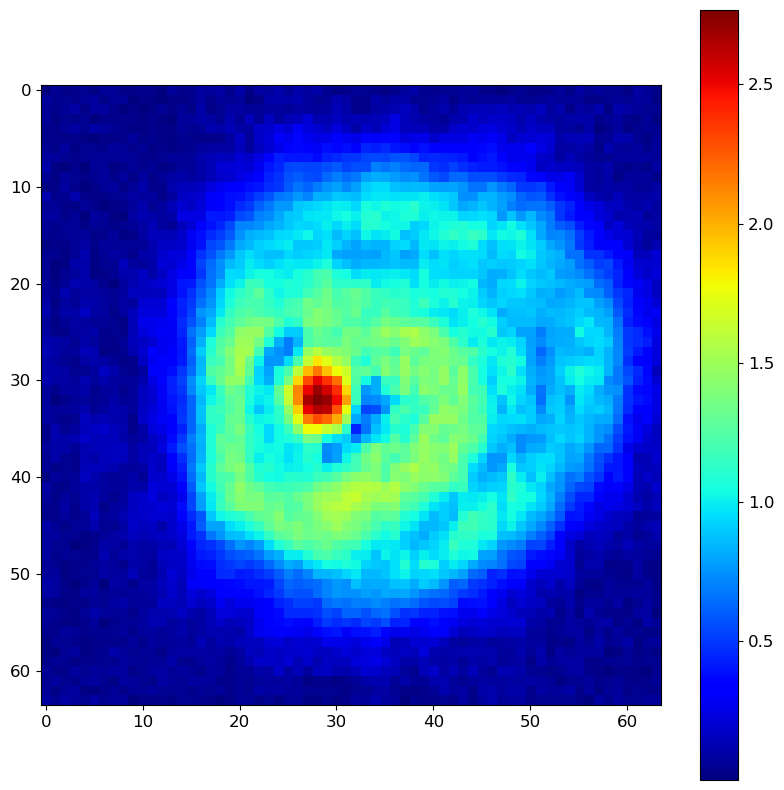

In [17]:
plt.imshow(np.abs(obj['probeGuess']), cmap = 'jet')
plt.colorbar()

In [4]:
np.mean(hh.pad_and_diffract(diff4d_nn[:, :, :, :1], 64, 64)[1]**2)

input shape (1024, 64, 64, 1)


0.30519545

In [5]:
datasets.scale_nphotons(diff4d_nn[:, :, :, :])

<tf.Tensor: shape=(), dtype=float64, numpy=894.7629608593265>

In [6]:
diff4d_nn.shape

(1024, 64, 64, 4)

In [7]:
def stack_coords(xcoords, ycoords, gridh, gridw):
    """
    Takes 1d coord arrays, returns array of shape (1, 2, gridh * gridw)
    """
    return np.array([xcoords, ycoords])[None, ...]

def to_4d(d3d, gridh, gridw):
    """
    Shape 3d data tensor to 4d
    """
    h, w = d3d.shape[:2]
    dgrid = np.transpose(d3d[:, :, :gridh * gridw], [2, 0, 1])
    return dgrid.reshape(gridh, gridw, h, w)

In [73]:
coords3d = stack_coords(xcoords, ycoords, gridh, gridw)
coords3d.shape

(1, 2, 1024)

In [80]:
np.abs(coords_nn - coords_start_nn).mean()

0.5625868095194588

In [71]:
list(obj.keys())

['diffraction',
 'probeGuess',
 'objectGuess',
 'xcoords',
 'ycoords',
 'xcoords_start',
 'ycoords_start']

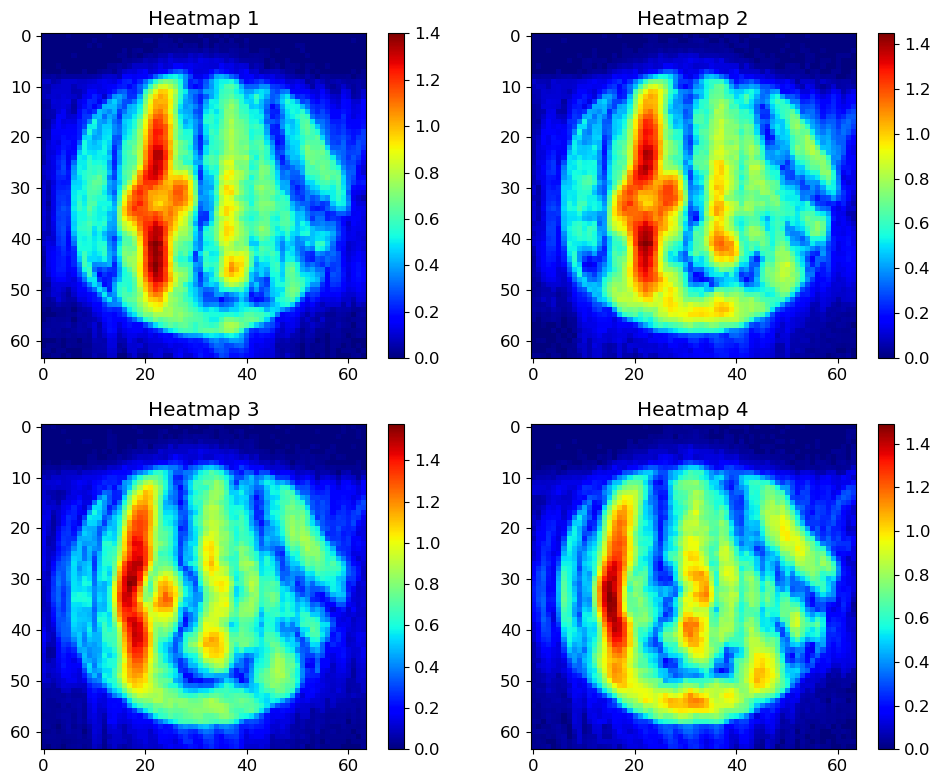

In [34]:
data = diff4d_nn[1000]

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Loop through the data and plot each heatmap in a subplot
for i in range(4):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    heatmap = ax.imshow(data[..., i], cmap='jet', interpolation='nearest')
    ax.set_title(f"Heatmap {i + 1}")
    fig.colorbar(heatmap, ax=ax)  # Add colorbar to each subplot

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [12]:
isort = np.argsort(xcoords)
vsort = ycoords[isort]

shp = (8, 32 * 2 * 2)

jjsort = np.argsort(vsort.reshape(shp), axis = 1)

In [13]:
ii, _ = np.indices(shp)

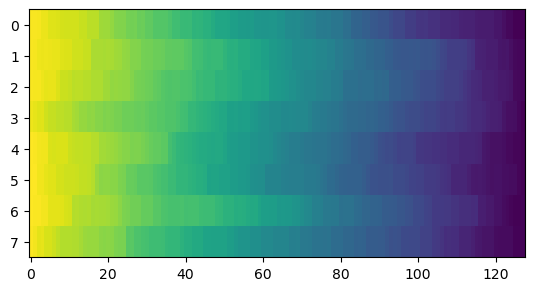

In [14]:
plt.imshow(isort.reshape(shp)[ii, jjsort], aspect = 8)

In [36]:
positions_scangrid = to_4d(coords3d, 32, 32)
X_scangrid = to_4d(obj['diffraction'], 32, 32)

isort_rows = np.argsort(positions_scangrid[:, :, :, 0], axis = 1)
def reorder_scangrid(arr):
    """
    Reorder so that positions are monotonic
    """
    ii, jj, kk, ll = np.indices(arr.shape)
    return arr[ii, isort_rows[..., None], kk, ll]

positions_scangrid = reorder_scangrid(positions_scangrid)
X_scangrid = reorder_scangrid(X_scangrid)

positions_scangrid.shape, X_scangrid.shape

((32, 32, 1, 2), (32, 32, 64, 64))

In [37]:
positions_scangrid.shape

(32, 32, 1, 2)

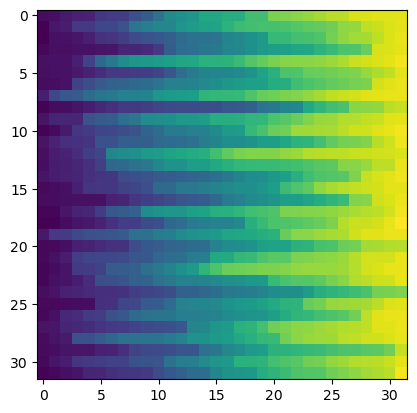

In [96]:
plt.imshow(positions_scangrid[:, :, 0, 0])

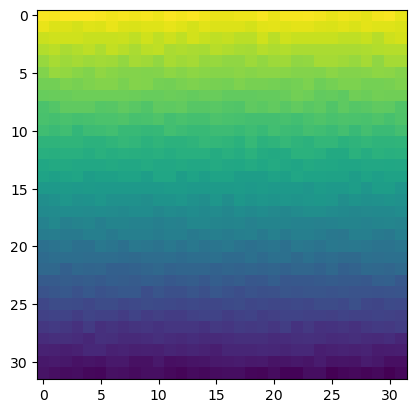

In [97]:
plt.imshow(positions_scangrid[:, :, 0, 1])

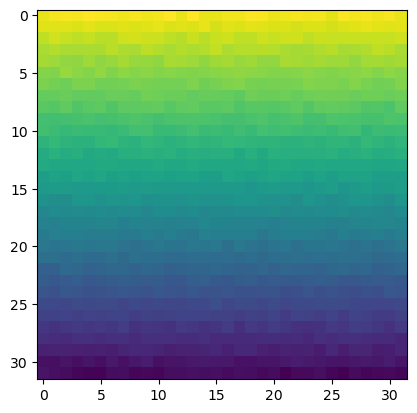

In [161]:
plt.imshow(reorder_scangrid(positions_scangrid)[:, :, 0, 1])

/var/folders/gf/vkyz_q256jnbdk8p30lf19xm0000gn/T/ipykernel_6815/3442418750.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(X_scangrid[10, 10, :, :]))


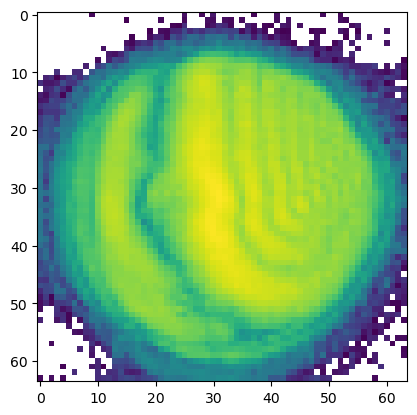

In [98]:
plt.imshow(np.log(X_scangrid[10, 10, :, :]))

In [90]:
def prepare_from_4d(diff4d, h, w):
    """
    Extract solution patches and return them in channel format, shape (b, h, w, c)
    """
    solution_regions_grid = hh.extract_patches(diff4d.reshape(1, 32, 32, h * w), gridsize, 1)
    solution_regions_channel = tf.reshape(solution_regions_grid, (-1, gridsize**2, h, w))
    return tf.transpose(solution_regions_channel, [0, 2, 3, 1], conjugate = False)

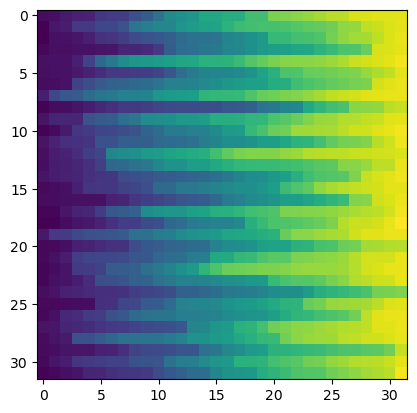

In [162]:
plt.imshow(positions_scangrid[:, :, 0, 0])

In [94]:
# diffraction data in the model's input format
X = prepare_from_4d(X_scangrid, N, N)

# scan point positions in the model's input format
positions = prepare_from_4d(positions_scangrid, 1, 2)

X.shape, positions.shape

(TensorShape([961, 64, 64, 4]), TensorShape([961, 1, 2, 4]))

<tf.Tensor: shape=(1, 2, 4), dtype=float64, numpy=
array([[[ 78.73525601,  78.79744924, 112.54909053, 115.64263298],
        [146.80767817, 145.42123453, 142.5542574 , 144.8813778 ]]])>

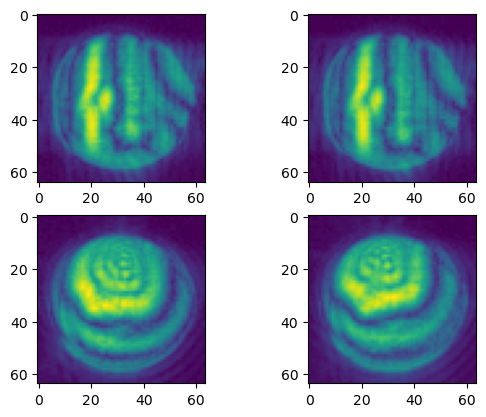

In [95]:
# four diffraction patterns from one solution grid
a, b = 2, 2
plt.subplot(a, b, 1)
plt.imshow(X[100, :, :, 0])

plt.subplot(a, b, 2)
plt.imshow(X[100, :, :, 1])

plt.subplot(a, b, 3)
plt.imshow(X[100, :, :, 2])

plt.subplot(a, b, 4)
plt.imshow(X[100, :, :, 3])

positions[100, :, :, :]

In [2]:
from importlib import reload
import matplotlib.pyplot as plt

from ptycho import params as p
from ptycho import generate_data as init
# from ptycho import train

Loading result from disk cache.
Loading result from disk cache.
0.9999917
nphoton 8.962649


In [3]:
p.cfg['outer_offset_train']

NameError: name 'p' is not defined

In [4]:
p.cfg['outer_offset_test']

NameError: name 'p' is not defined

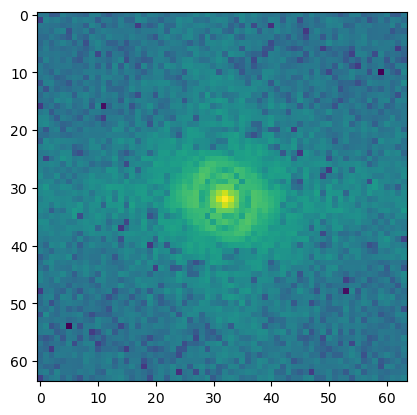

In [170]:
plt.imshow(
    np.log(np.absolute(np.fft.fftshift(np.fft.fft2(np.absolute(obj['probeGuess']))))))

In [6]:
from ptycho import tf_helper as hh

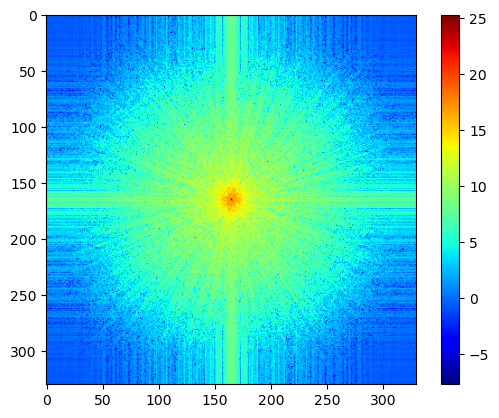

In [7]:
from ptycho import evaluation as eval
import numpy as np
reload(eval)

F2 = np.absolute(eval.fft2d(np.absolute(init.YY_ground_truth[:, :, 0])))**2

plt.imshow(np.log(F2[:, :]), cmap = 'jet')
plt.colorbar()

In [8]:
size = (np.array(init.YY_ground_truth[:, :, 0]).size)

## Full PINN model, best params:

In [10]:
# plt.plot(d['frc'][0])
# plt.plot(d['frc'][1])


In [11]:
d = save_metrics(stitched_obj, YY_ground_truth, label = 'PINN,NLL,overlaps')
d
#d0 = d

subtracting mean 0.06457644
subtracting mean 0.15387884
mean scale adjustment: 4.346844
mean scale adjustment: 4.346844
performed by index method
performed by index method
performed by index method
mean scale adjustment: 1
mean scale adjustment: 1
performed by index method
performed by index method
performed by index method


{'mae': (0.036913663, 0.014299419),
 'mse': (0.0026327244, 0.0003312106),
 'psnr': (73.9267499156581, 82.92976135806056),
 'frc50': (165, 165)}

In [14]:
d = save_metrics(stitched_obj, YY_ground_truth, label = 'PINN,NLL,overlaps')
d
#d0 = d

subtracting mean -0.18307073
subtracting mean 0.15387884
mean scale adjustment: 4.566107
mean scale adjustment: 4.566107
performed by index method
performed by index method
performed by index method
mean scale adjustment: 1
mean scale adjustment: 1
performed by index method
performed by index method
performed by index method


{'mae': (0.18717046, 0.10040524),
 'mse': (0.052955687, 0.015191995),
 'psnr': (60.89167790517977, 66.31465531094665),
 'frc50': (22, 20)}

In [12]:
stitched_phase = np.angle(stitched_obj)#init.stitch(b, 1, norm = False, nsegments = params()['nsegments'],
                       #part = 'phase')

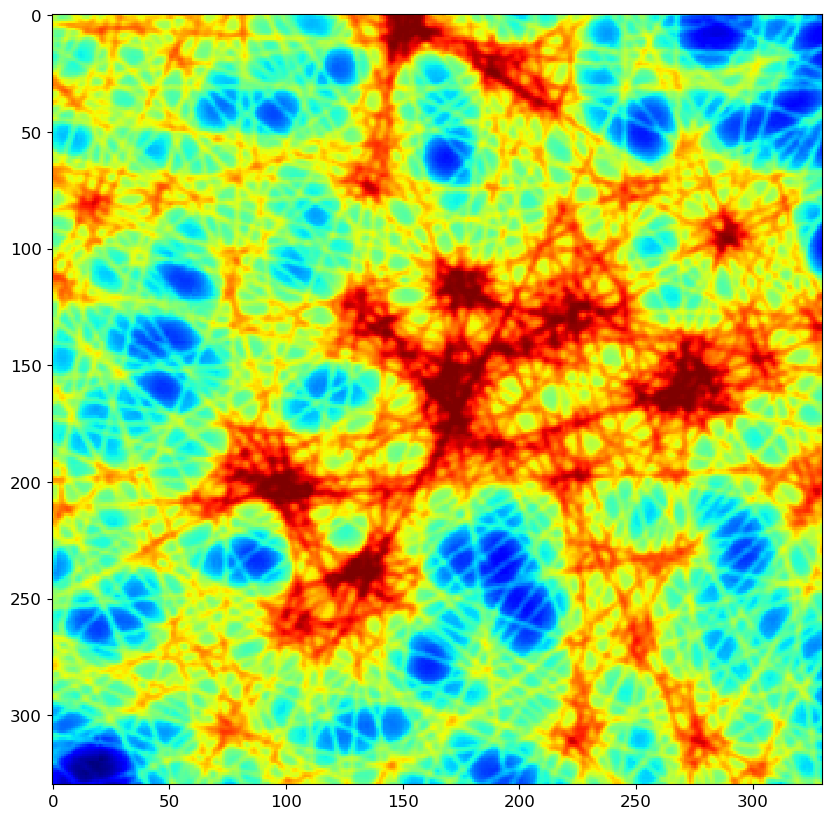

In [12]:
plt.rcParams["figure.figsize"] = (10, 10)
 
import matplotlib.pyplot as plt
plt.imshow(np.absolute(stitched_obj)[0], cmap = 'jet', interpolation='none')

In [12]:
stitched_obj.shape

(2, 330, 330, 1)

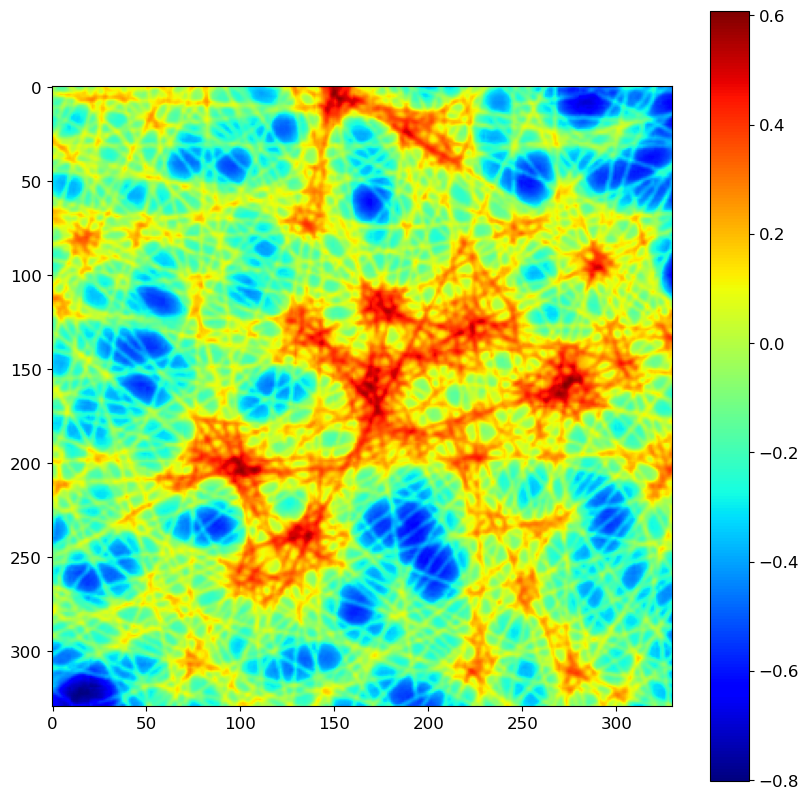

In [13]:
plt.rcParams["figure.figsize"] = (10, 10)

plt.imshow(np.angle(stitched_obj)[0], cmap = 'jet')
plt.colorbar()